<a href="https://colab.research.google.com/github/wantor-stack/Coursera_Capstone/blob/main/Notebook_Analyzing_the_Neighborhoods_of_Rio_de_Janeiro_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Data Science Capstone- Battle of the Neighborhoods
## Analyzing the Neighborhoods of Rio de Janeiro, RJ

## Author: Wanderson Torres

### Introduction/ Business Problem:

With the pandemic infecting the planet, most jobs have gone remote, thus giving people an option to move farther away from the office to a safety area. We have seen a trend where people are moving away from crowded and expensive big cities to the suburbs or even to other states where there is more secure and more protected against the virus. 

I live in the city of Rio de Janeiro and due to the increase in the number of deaths and the occupation of hospital beds reaching their maximum occupancy, I would like to conduct a study where it points out areas of lower risk and high options for health treatment in general. 

The aim of the project is to apply the skills learned in the Coursera course to find the safest neighborhood in Rio de Janeiro, surrounded by hospitals, drugstores, clinics and so on. This will be determined by analyzing the number of cases of covid, deaths and the profile of the neighborhoods population, clustering neighborhoods using k-means and exploring the top common healthy venues in the safest neighborhoods. 

This exercise may also be of interest to anyone who is facing this pandemic and is concerned about the health issue.

### Data

The Rio Covid Panel is an initiative of the city of Rio de Janeiro. It's a open source and available for download directly from the Data Rio Website [website](https://www.data.rio/app/painel-rio-covid-19). It contained the features about COVID cases: neighborhood of residence, case evolution, age group and sex. 

I also obtained a list of Rio de Janeiro’s districts and neighborhoods by web scraping a [Wikipedia page](https://pt.wikipedia.org/wiki/Lista_de_bairros_da_cidade_do_Rio_de_Janeiro) using BeautifulSoup. However, this dataset lacked the geographical coordinates. So, I used geocoder to obtain the latitude and longitude coordinates for each Rio de Janeiro neighborhood.

To get venue information in each neighborhood, I called the [Foursquare API](https://foursquare.com/developers/apps). This gave me a dataset containing the venue name, latitude and longitude coordinates of the venue location, and the venue category.

#### Let's first install the necessary libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if geopy package is not installed
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.exc import GeocoderTimedOut 

import requests # library to handle requests

#!pip install BeautifulSoup4
from bs4 import BeautifulSoup # for web scraping

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import seaborn to make pretty plots
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium package is not installed
#!pip install folium
import folium # map-rendering library

print('Libraries imported.')

Libraries imported.


## 1. Gather Rio de Janeiro neighborhood and district information from the web

- Scrape wikipedia page for Rio de Janeiro neighborhoods and save as csv file
- Use geocoder to get latitude and longitude coordinates
- Export dataframe into csv for future use
- (Read the csv file and put into a dataframe)
- data cleanup- delete the rows where coordinates couldn't be found
- Visualize the map of these neighborhoods

### 1.1 - Web Scraping
####First, let's scrape the wikipedia page for a list of Rio de Janeiro's neighborhoods and districts

In [106]:
#scrape wikipedia for Seattle neighborhoods
url = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_da_cidade_do_Rio_de_Janeiro'
html = requests.get(url).text
soup = BeautifulSoup(html, 'html.parser')

tables = soup.find_all('table')
neighborhood_rj=pd.read_html(str(tables[0]), flavor='bs4')[0]
neighborhood_rj = pd.DataFrame(neighborhood_rj)

### 1.2 Data Cleaning
#### Then, we need to clean up the dataset

In [107]:
#Take a look in the dataset
neighborhood_rj.head()

,0,1,2,3
0,Bairros oficiais,Bairros oficiais,Bairros oficiais,Bairros oficiais
1,Zona,Subprefeitura(nº de bairros),Bairros[6],Imagens
2,Central,Centro Histórico e Zona Portuária (16)[7][8],Bairro Imperial de São Cristóvão • Benfica • C...,NaN
3,Sul,Zona Sul (17)[9],Botafogo • Catete • Copacabana • Cosme Velho •...,NaN
4,Oeste,Barra da Tijuca e Baixada de Jacarepaguá (20),Anil • Barra da Tijuca • Camorim • Cidade de D...,NaN


In [108]:
# clean up the last column
neighborhood_rj.drop(3, axis=1, inplace=True)

#Drop thee first 2 rows 
neighborhood_rj.drop(neighborhood_rj.index[[0,1]], inplace=True)

#Rename the columns
neighborhood_rj.rename(columns = {0:'Zone', 1:'District', 2:'Neighborhood'}, inplace = True)

#Split the District Column by '('
neighborhood_rj[['District','0']] = neighborhood_rj['District'].str.split('(',expand=True)

#Drop Column 0 and reset index
neighborhood_rj.drop('0', axis=1, inplace=True)
neighborhood_rj.reset_index(inplace=True)
neighborhood_rj.drop('index', axis=1, inplace=True)

#Split the Neighborhood column in rows
neighborhood_rj = (neighborhood_rj.set_index(['Zone', 'District'])
   .apply(lambda x: x.str.split('•').explode())
   .reset_index())

#Insert the name of the city
neighborhood_rj.insert(0, 'City', ['Rio de Janeiro' for x in range(0, len(neighborhood_rj))])

#Replace the name of one Neighborhood
neighborhood_rj['Neighborhood'] = neighborhood_rj.Neighborhood.str.replace('Bairro Imperial de São Cristóvão', 'São Cristóvão')

#Strip the blaked spaces
neighborhood_rj['Neighborhood'] = neighborhood_rj['Neighborhood'].str.strip()

In [109]:
neighborhood_rj.head()

,City,Zone,District,Neighborhood
0,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,São Cristóvão
1,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Benfica
2,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Caju
3,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Catumbi
4,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Centro


#### To bypass the webscraping process in the future, I have saved the dataframe to a csv. Now, we can import the list of Rio de Janeiro neighborhoods and districts from a csv directly to save time.

In [110]:
# Save Rio de Janeiro neighborhoods to csv
neighborhood_rj.to_csv('rio-rj-neighborhoods.csv', index = False)

In [111]:
# TO IMPORT THE CLEANED RIO DE JANEIRO DATAFRAME FROM THE GETGO

# load the dataset
rj_data = pd.read_csv('rio-rj-neighborhoods.csv', header=0)
#print the dataset
rj_data.head()

,City,Zone,District,Neighborhood
0,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,São Cristóvão
1,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Benfica
2,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Caju
3,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Catumbi
4,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Centro


### 1.3 - With this dataframe of neighborhoods and districts, we will get the latitude and longitude coordinates by using geocoder.

In [112]:
locator = Nominatim(user_agent="wqt_explorer")
def get_latlng(address):
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    #while(lat_lng_coords is None):
    coordinate = locator.geocode('{}, Rio de Janeiro'.format(address)) #geopy
    lat_lng_coords = coordinate.latitude, coordinate.longitude
    return lat_lng_coords


In [113]:
# declare latitude and longitude as an empty list to initialize
latitude = []
longitude = []

# Use function get_latlng to get latitude and longitude for every neighborhood in the dataset  
for address in (rj_data["Neighborhood"]):
    loc = get_latlng(address)
    if loc != None:
        print(address)
        #loc = get_latlng(address)
        # returned coordinates returned are stored into the latitude and longitude list
        latitude.append(loc[0])
        longitude.append(loc[1])
        
        #if coordinates are not found, insert "NaN" indicating missing value
    else:
        print(i + ", RJ")
        latitude.append(np.nan)
        longitude.append(np.nan)

São Cristóvão
Benfica
Caju
Catumbi


KeyboardInterrupt: ignored

#### We can now append the geographical coordinates to the dataframe and clean up the dataset by dropping any rows where coordinates weren't found.

In [ ]:
# Add latitude and longitude data to dataframe
rj_data["Latitude"] = latitude
rj_data["Longitude"] = longitude

In [ ]:
rj_data.head()

In [ ]:
#Drop rows where coordinates weren't found
rj_data.dropna(subset=['Latitude'], inplace=True)
rj_data.reset_index(drop=True, inplace=True)


In [ ]:
#Drop Mangueira and Olaria --> Incorrect geocoordinates
rj_data.drop([116,9],  axis=0, inplace=True)
rj_data.head()

In [ ]:
#Reset Index
rj_data.reset_index(drop=True, inplace=True)
rj_data.isnull().sum()

#### Calling geocoder on all the neighborhoods took a lot of time, so to save time in the future I have saved the dataframe to a csv. Now, we can import the list of Seattle neighborhoods and districts, as well as their geographical coordinates, from a csv.

In [ ]:
# Save dataframe to csv
rj_data.to_csv('rio-rj-neighborhoods-geo.csv', index = False)

In [ ]:
# TO IMPORT RIO DE JANEIRO DATAFRAME WITH COORDINATES FROM THE GETGO
rj_data = pd.read_csv('rio-rj-neighborhoods-geo.csv', header=0)
#rj_data.dropna(subset=['Latitude'], inplace=True)
#rj_data.reset_index(drop=True, inplace=True)
rj_data.head()

#### This is how many neighborhoods and districts there are in the dataframe.

In [ ]:
# Print the number of districts and neighborhoods in the dataframe
print('The dataframe has {} districts and {} neighborhoods.'.format(
        len(rj_data['District'].unique()),
        rj_data.shape[0]
    )
)

#### Let's create a map to visualize all these neighborhoods.

In [ ]:
# Get the geographical coordinates of Seattle
address = 'Rio de Janeiro, RJ'

geolocator = Nominatim(user_agent="rj_explorer")
location_rio = geolocator.geocode(address)
latitude_rio = location_rio.latitude
longitude_rio = location_rio.longitude
print('The geographical coordinates of Rio de Janeiro are {}, {}.'.format(latitude_rio, longitude_rio))

In [ ]:
# Create map of King County using latitude and longitude values
map_rio = folium.Map(location=[latitude_rio, longitude_rio], zoom_start=10)

# add markers to map
for lat, lng, district, neighborhood in zip(rj_data['Latitude'], rj_data['Longitude'], rj_data['District'], rj_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rio)  
    
map_rio

In [ ]:
#save the map as HTML file
map_rio.save('map_rio.html')

## 2. Get Rio de Janeiro COVID Dataset
The Rio de Janeiro dataset was downloaded from the **Data Rio website** directly and saved as a csv file on my local drive. Now, I just have to import it and see what's in it.

In [ ]:
rj_covid = pd.read_csv('db_PainelRioCovid.csv', header=0, sep=';')
rj_covid.head()

,bairro_resid_estadia,sexo,faixa_etaria,evolucao,raca_cor
0,ABOLICAO,F,De 70 a 79,OBITO,Preta
1,ABOLICAO,F,De 90 a 99,OBITO,Parda
2,ABOLICAO,F,De 70 a 79,OBITO,Branca
3,ABOLICAO,M,De 40 a 49,OBITO,Preta
4,ABOLICAO,M,De 70 a 79,OBITO,Parda


#### Let's check the size of the dataset.

In [ ]:
# check the number of rows and columns
rj_covid.shape

(243790, 5)

#### The dataset is rather large with a lot of rows. So, let's do some data cleaning.

In [ ]:
# Keep only the columns I'm interested in
#crime = crime[['Offense Parent Group','Offense','MCPP','Latitude','Longitude']]
# rename the column titles
rj_covid.rename(columns={"bairro_resid_estadia": "Neighborhood", "sexo": 'sex', 'faixa_etaria': 'age_group', 'evolucao':'evolution', 'raca_cor': 'race'}, inplace=True)
rj_covid.head()

,Neighborhood,sex,age_group,evolution,race
0,ABOLICAO,F,De 70 a 79,OBITO,Preta
1,ABOLICAO,F,De 90 a 99,OBITO,Parda
2,ABOLICAO,F,De 70 a 79,OBITO,Branca
3,ABOLICAO,M,De 40 a 49,OBITO,Preta
4,ABOLICAO,M,De 70 a 79,OBITO,Parda


In [ ]:
print("The rj_covid dataset has ", str(rj_covid.shape[0]), " cases in ", str(len(rj_covid["Neighborhood"].unique())), " neighborhoods in Rio de Janeiro.")

The rj_covid dataset has  243790  cases in  164  neighborhoods in Rio de Janeiro.


### we can notice that there are 20000 records with the undefined neighborhood

In [ ]:
rj_covid["Neighborhood"].value_counts()

INDEFINIDO                  20010
BARRA DA TIJUCA              9999
TIJUCA                       9153
CAMPO GRANDE                 8499
COPACABANA                   8137
SANTA CRUZ                   6234
BOTAFOGO                     5471
RECREIO DOS BANDEIRANTES     5288
JACAREPAGUA                  5145
BANGU                        4810
TAQUARA                      4511
FORA DO MUNICIPIO            4375
REALENGO                     3940
CENTRO                       3699
VILA ISABEL                  3533
LEBLON                       3359
FLAMENGO                     3171
PACIENCIA                    3116
MEIER                        3028
IRAJA                        2954
FREGUESIA-JPA                2828
BONSUCESSO                   2789
IPANEMA                      2770
RAMOS                        2688
LARANJEIRAS                  2208
ENGENHO DE DENTRO            2111
MARE                         2035
INHAUMA                      2024
PENHA                        1993
SEPETIBA      

### Although it is a high value for undefined neighborhoods, I chose to remove the lines for 2 reasons: First, I consider, for this academic work, there is enough data for clustering, in the second, the data taken represents less than 10% of the total.

In [ ]:
rj_covid.drop(index=rj_covid[rj_covid["Neighborhood"]=='INDEFINIDO'].index, inplace=True)
rj_covid.drop(index=rj_covid[rj_covid["Neighborhood"]=='FORA DO MUNICIPIO'].index, inplace=True)

In [ ]:
rj_covid.shape

(219405, 5)

In [ ]:
rj_covid["age_group"].value_counts()

De 30 a 39      45546
De 40 a 49      43661
De 50 a 59      35537
De 60 a 69      27236
De 20 a 29      27002
De 70 a 79      16270
De 80 a 89       8958
De 10 a 19       6462
N/D              3047
De 0 a 9         2854
De 90 a 99       2698
Maior de 100      134
Name: age_group, dtype: int64

### For the same reasons above, I prefer to drop rows with N/D age group

In [ ]:
rj_covid.drop(index=rj_covid[rj_covid["age_group"]=='N/D'].index, inplace=True)
rj_covid.shape

(216358, 5)

### For the same reasons above, I prefer to drop rows with I in the sex group

In [ ]:
rj_covid["sex"].value_counts()

F    115742
M    100610
I         6
Name: sex, dtype: int64

In [ ]:
rj_covid.drop(index=rj_covid[rj_covid["sex"]=='I'].index, inplace=True)
rj_covid.shape

(216352, 5)

### Let's reset the index

In [ ]:
rj_covid.reset_index(drop=True, inplace=True)

In [ ]:
rj_covid.head()

,Neighborhood,sex,age_group,evolution,race
0,ABOLICAO,F,De 70 a 79,OBITO,Preta
1,ABOLICAO,F,De 90 a 99,OBITO,Parda
2,ABOLICAO,F,De 70 a 79,OBITO,Branca
3,ABOLICAO,M,De 40 a 49,OBITO,Preta
4,ABOLICAO,M,De 70 a 79,OBITO,Parda


In [ ]:
# Save dataframe to csv
rj_covid.to_csv('rj_covid.csv', index = False)

In [4]:
# TO IMPORT RIO DE JANEIRO DATAFRAME WITH COORDINATES FROM THE GETGO
rj_covid = pd.read_csv('rj_covid.csv', header=0)
#rj_data.dropna(subset=['Latitude'], inplace=True)
#rj_data.reset_index(drop=True, inplace=True)
rj_covid.head()

,Neighborhood,sex,age_group,evolution,race
0,ABOLICAO,F,De 70 a 79,OBITO,Preta
1,ABOLICAO,F,De 90 a 99,OBITO,Parda
2,ABOLICAO,F,De 70 a 79,OBITO,Branca
3,ABOLICAO,M,De 40 a 49,OBITO,Preta
4,ABOLICAO,M,De 70 a 79,OBITO,Parda


## 3. Exploratory Data Analysis of COVID in Rio de Janeiro Neighborhoods
#### Let's look at the Dataset using Pandas Profiling`

In [ ]:
#!pip install -U pandas-profiling

In [ ]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(rj_covid, title='Profiling COVID RIO',html={'style':{'full_width':True}})

In [ ]:
# profile.to_notebook_iframe()

Text(0.5, 1.0, 'Male/Female Ratio')

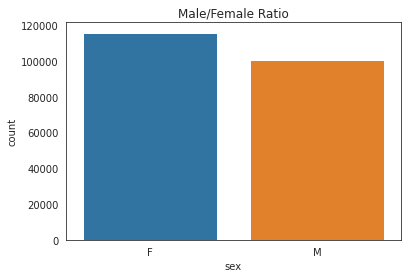

In [ ]:
# Visualize male/female ratio
sns.set_style('white')
sns.countplot(x=rj_covid["sex"]).set_title("Male/Female Ratio")

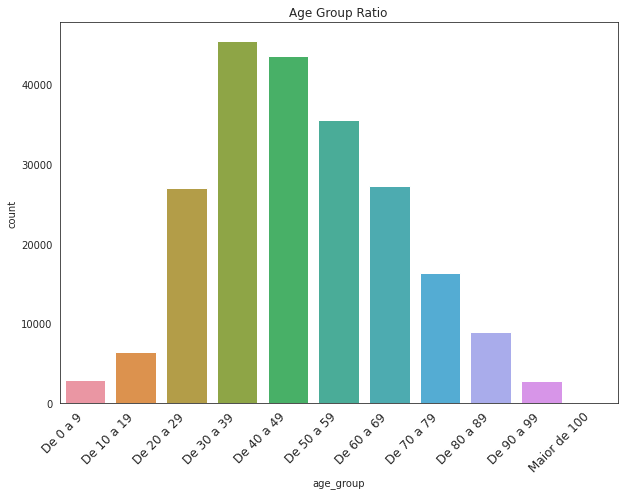

In [ ]:
# Visualize age group ratio
countplt, ax = plt.subplots(figsize = (10,7))
ax.set_title("Age Group Ratio")
age_order = ['De 0 a 9','De 10 a 19','De 20 a 29','De 30 a 39','De 40 a 49','De 50 a 59','De 60 a 69','De 70 a 79','De 80 a 89','De 90 a 99','Maior de 100']
ax = sns.countplot(x=rj_covid["age_group"], order = age_order).set_xticklabels(age_order, fontsize=12, rotation=45, ha='right');

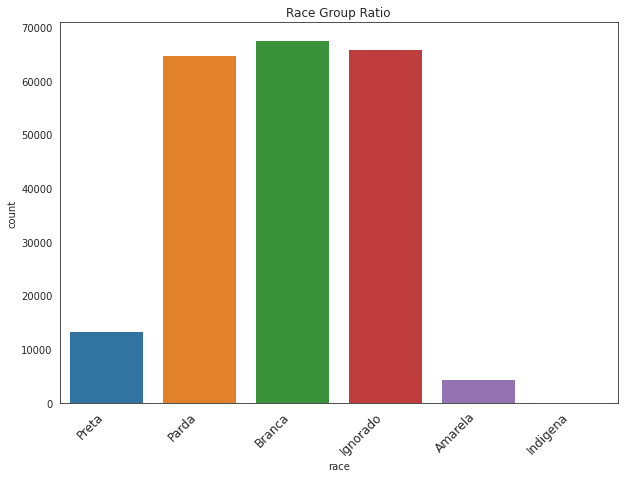

In [ ]:
# Visualize race ratio
countplt, ax = plt.subplots(figsize = (10,7))
ax.set_title("Race Group Ratio")
race = ['Preta', 'Parda', 'Branca', 'Ignorado', 'Amarela', 'Indigena']
ax = sns.countplot(x=rj_covid["race"]).set_xticklabels(race, fontsize=12, rotation=45, ha='right');

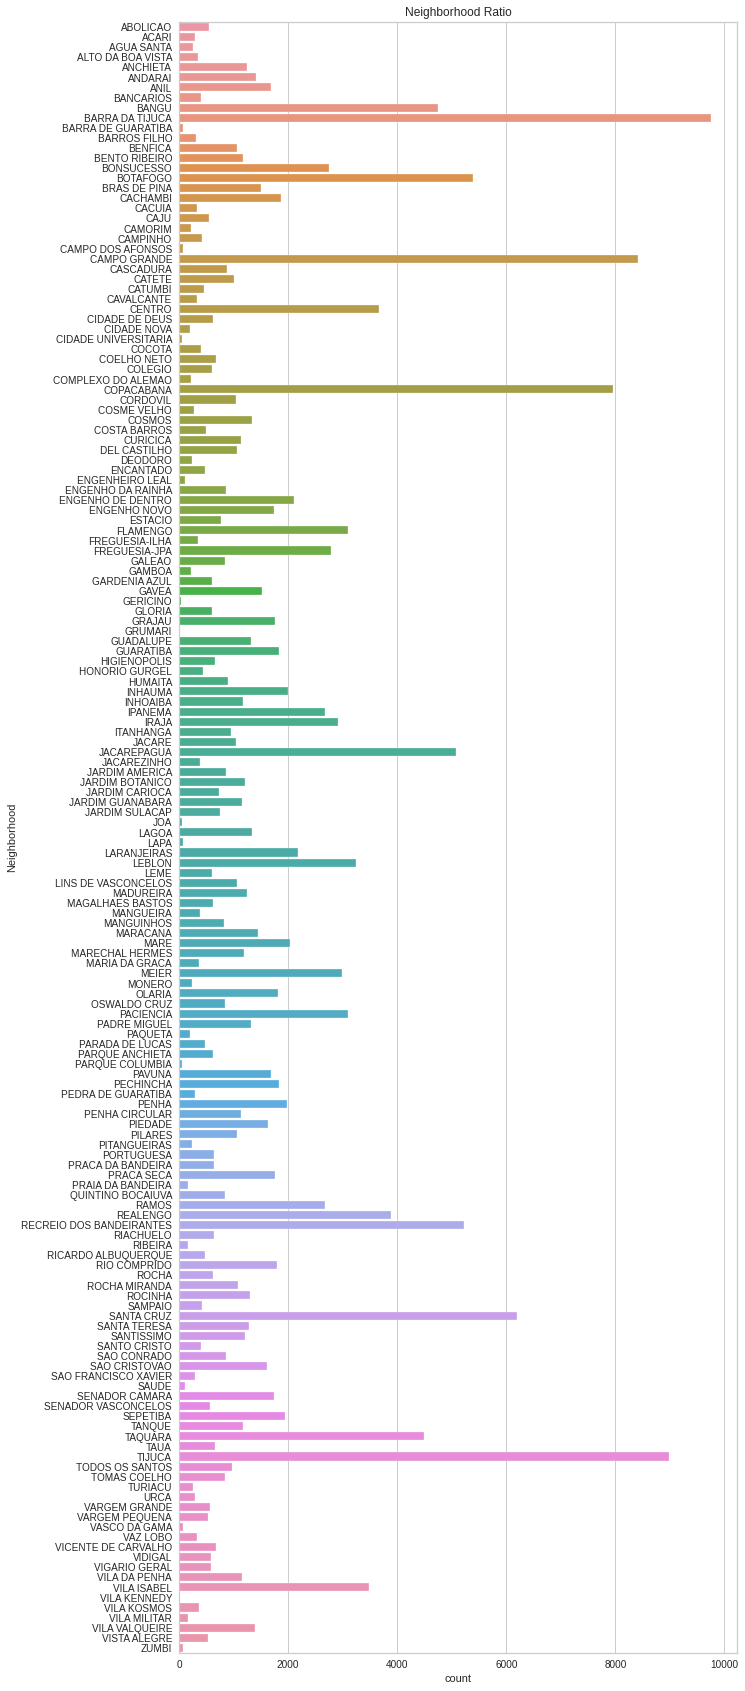

In [234]:
# Visualize race ratio
countplt, ax = plt.subplots(figsize = (10,30))
ax.set_title("Neighborhood Ratio")
ax = sns.countplot(y=rj_covid["Neighborhood"])

#### Now let's break it down by Neighborhood. How many times have each type of evolution occurred per neighborhood?

In [ ]:
# Looking at the number of cases per type evolution by age group
covid_neighborhood = pd.DataFrame(rj_covid.groupby(['Neighborhood', 'evolution']).size().rename('Covid Cases').reset_index())
covid_neighborhood.head()

,Neighborhood,evolution,Covid Cases
0,ABOLICAO,ATIVO,38
1,ABOLICAO,OBITO,47
2,ABOLICAO,RECUPERADO,464
3,ACARI,ATIVO,11
4,ACARI,OBITO,53


#### Hmm that was hard to visualize. Maybe turning it into a box plot would make it easier to read.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


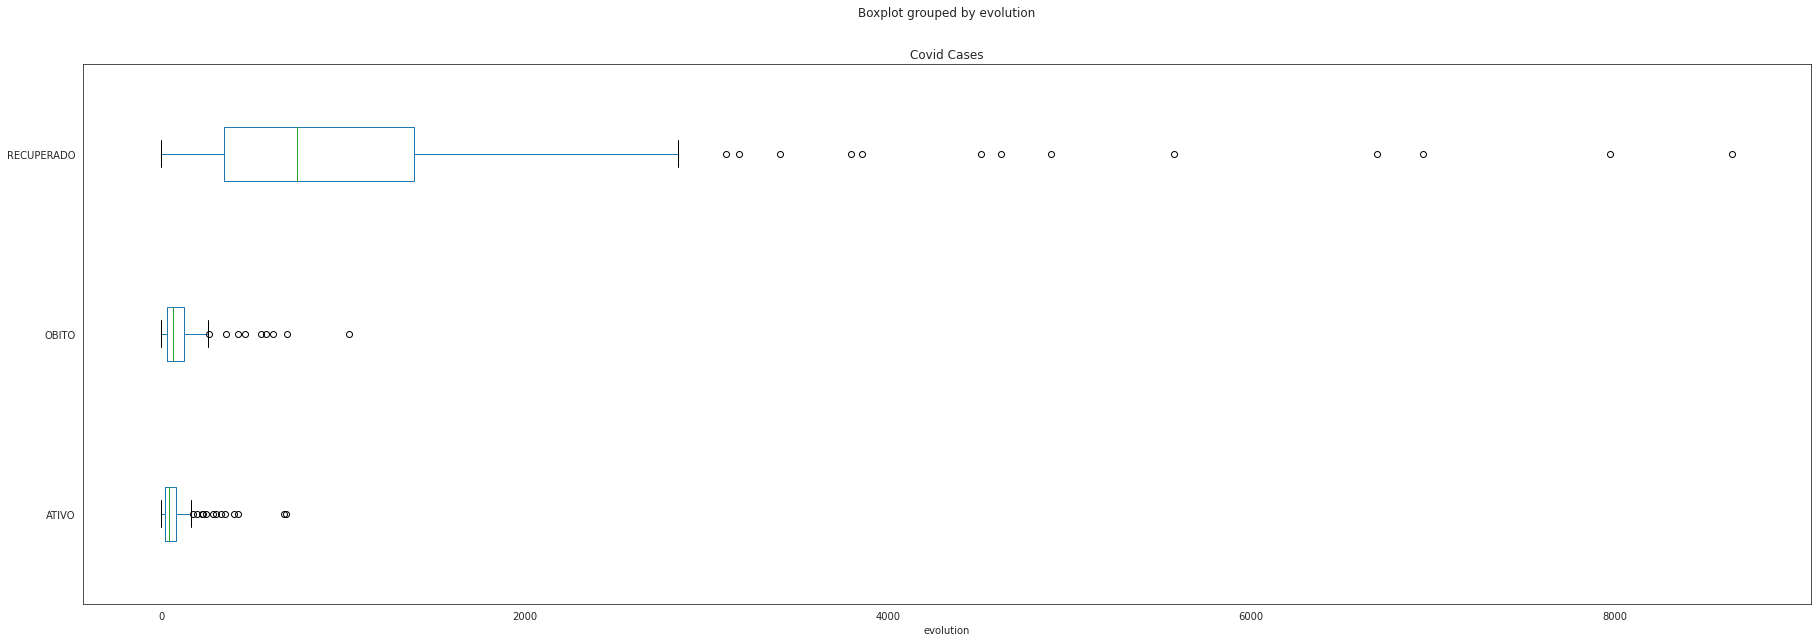

In [ ]:
import matplotlib.pyplot as plt 
% matplotlib inline

covid_neighborhood.boxplot(by ='evolution', column =['Covid Cases'], vert=False, figsize=[30,10], grid = False)

#### Which Rio de Janeiro neighborhood should I stay away from because they had the most number of covid cases?

In [ ]:
# Make a pivot table of the count evolution cases per neighborhood
covid_pivot = covid_neighborhood.pivot_table("Covid Cases", "Neighborhood", "evolution")


In [ ]:
# Make a Total column that adds up the total count of offenses per district
covid_pivot["Total"] = covid_pivot.sum(axis=1)
#covid_pivot.reset_index(inplace=True)
covid_pivot.head()

evolution,ATIVO,OBITO,RECUPERADO,Total
Neighborhood,,,,
ABOLICAO,38.0,47.0,464.0,549.0
ACARI,11.0,53.0,233.0,297.0
AGUA SANTA,15.0,21.0,217.0,253.0
ALTO DA BOA VISTA,21.0,33.0,302.0,356.0
ANCHIETA,60.0,104.0,1075.0,1239.0


In [ ]:
# Sort the covid pivot table by the Totals column from highest number of cases to lowest
covid_sort = pd.DataFrame(covid_pivot['Total'].sort_values(ascending=False))
# show the top 10 neighborhood with the highest number of cases
print("These are the top 10 districts with the highest number of cases:")
covid_sort.head(10)

These are the top 10 districts with the highest number of cases:


,Total
Neighborhood,
BARRA DA TIJUCA,9744.0
TIJUCA,8991.0
CAMPO GRANDE,8407.0
COPACABANA,7958.0
SANTA CRUZ,6187.0
BOTAFOGO,5384.0
RECREIO DOS BANDEIRANTES,5230.0
JACAREPAGUA,5083.0
BANGU,4749.0


#### Which Rio de Janeiro Neighborhoods are the safest because they had the least amount of cases?

In [ ]:
#show the bottom 10 neighborhoods with the lowest number of cases
print("These are the 10 neighborhoods with the lowest number of cases:")
covid_sort.tail(10)

These are the 10 neighborhoods with the lowest number of cases:


,Total
Neighborhood,
LAPA,80.0
ZUMBI,78.0
BARRA DE GUARATIBA,78.0
VASCO DA GAMA,68.0
PARQUE COLUMBIA,62.0
CIDADE UNIVERSITARIA,48.0
JOA,47.0
GERICINO,40.0
VILA KENNEDY,23.0


#### Now we can combine the safest and unsafest neighborhoods in a bar chart to better visualize it.

In [ ]:
# Create new dataframe with the top and bottom 10 neighborhoods according to total number of cases
covid_sort_hilo = pd.concat([covid_sort.head(10), covid_sort.tail(10)]).sort_values(by=["Total"], ascending=False)
covid_sort_hilo

,Total
Neighborhood,
BARRA DA TIJUCA,9744.0
TIJUCA,8991.0
CAMPO GRANDE,8407.0
COPACABANA,7958.0
SANTA CRUZ,6187.0
BOTAFOGO,5384.0
RECREIO DOS BANDEIRANTES,5230.0
JACAREPAGUA,5083.0
BANGU,4749.0


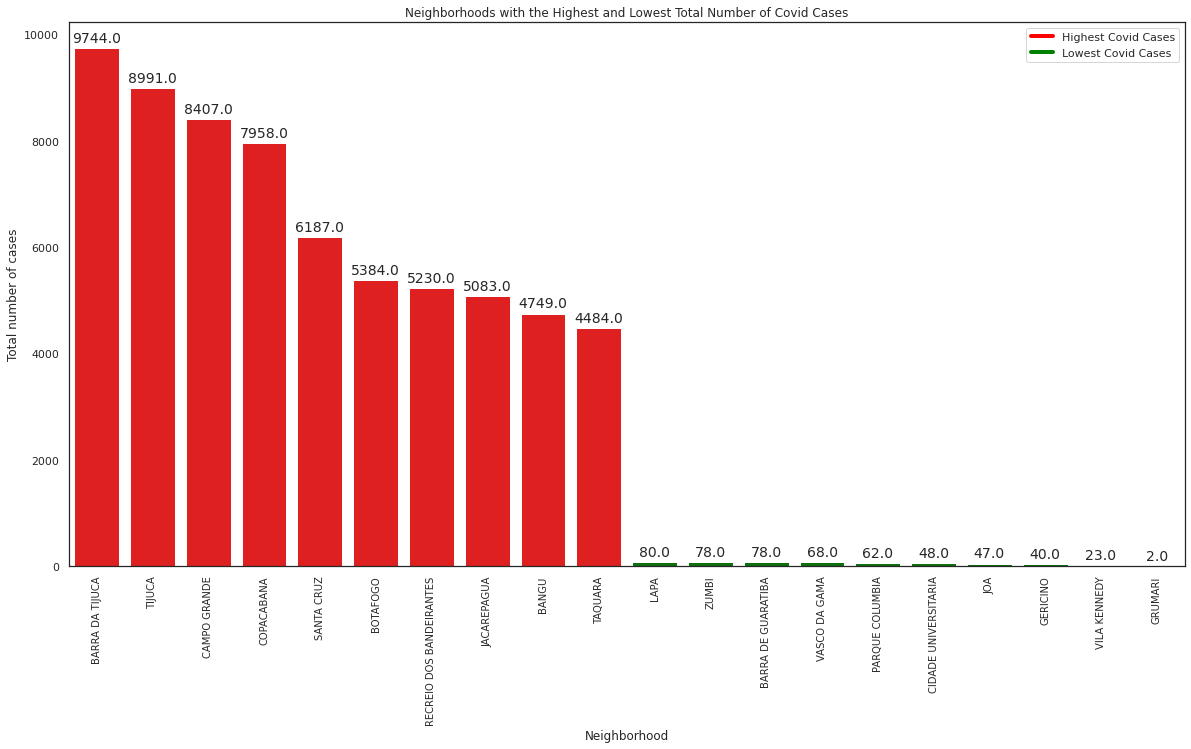

In [ ]:
# Visualize the top and bottom 10 neighborhoods by number of total cases

import seaborn as sns
from matplotlib.lines import Line2D

sns.set(style="white")

# create the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 10))
colors = ["red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "green", "green", "green", "green", "green", "green", "green", "green", "green", "green", "green"]
custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4)]

# plot the graph of Total number of cases in each neighborhood
barplot_alltypes = sns.barplot(x=covid_sort_hilo.index, y="Total", data=covid_sort_hilo, palette=colors)

# set the axis labels
ax.set_title('Neighborhoods with the Highest and Lowest Total Number of Covid Cases') # add title to the plot
ax.set(ylabel="Total number of cases", xlabel="Neighborhood")
ax.legend(custom_lines, ['Highest Covid Cases', 'Lowest Covid Cases'])

# rotate xticklabels
barplot_alltypes.set_xticklabels(barplot_alltypes.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize='small'
                        )

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## 4. Get the Rio de Janeiro Population Dataset


### Import and Cleaning Rio de Janeiro Population Dataset

In [83]:
# IMPORT RIO DE JANEIRO DATAFRAME WITH POPULATION
rj_pop = pd.read_csv('pop_total_bairro_rj.csv', header=0, sep=';')

# Rename the columns
rj_pop.rename(columns = {'Áreas de Planejamento, Regiões Administrativas e Bairros'	:'Neighborhood', 'Total':'Population'}, inplace = True)

# Remove special caracters
lst = rj_pop['Neighborhood'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
rj_pop['Neighborhood'] = lst

# UPPER CASE
rj_pop['Neighborhood'] = rj_pop['Neighborhood'].str.upper()

# Remove spaces
rj_pop['Neighborhood'] = rj_pop['Neighborhood'].str.strip()
rj_pop['Population'] = rj_pop['Population'].str.replace(" ","").str.strip()

#Transform integer
rj_pop['Population'] = rj_pop['Population'].astype('int')
rj_pop.head()

,Neighborhood,Population
0,COPACABANA,161031
1,LEBLON,50648
2,IPANEMA,47017
3,FLAMENGO,55047
4,MEIER,54811


In [34]:
rj_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Neighborhood  160 non-null    object
 1   Population    160 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ KB


## 5. One Hot Encoding and Merge Datasets
#### To do that, we gotta first use one-hot encoding to turn our categorical variables (the age group, sex, race and evolution)  in our dataset into a binary vector.

In [8]:
# Multiple categorical columns
categorical_cols = ['sex', 'age_group', 'evolution', 'race']
# one hot encoding
rj_onehot = pd.get_dummies(rj_covid, columns=categorical_cols, prefix="", prefix_sep="")

# add district column to onehot encoding dataframe
rj_onehot["Neighborhood"] = rj_covid["Neighborhood"]
print(rj_onehot.shape)
rj_onehot.head()

(216352, 23)


,Neighborhood,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta
0,ABOLICAO,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,ABOLICAO,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,ABOLICAO,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3,ABOLICAO,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,ABOLICAO,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0


#### After that, we can take the sum when grouping by Neighborhood. 

In [9]:
rj_grouped = rj_onehot.groupby(["Neighborhood"]).sum().reset_index()
print(rj_grouped.shape)
rj_grouped.head()

(162, 23)


,Neighborhood,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta
0,ABOLICAO,299.0,250.0,3.0,16.0,76.0,113.0,124.0,74.0,78.0,41.0,20.0,4.0,0.0,38.0,47.0,464.0,9.0,191.0,132.0,0.0,174.0,43.0
1,ACARI,162.0,135.0,1.0,7.0,51.0,56.0,51.0,46.0,47.0,23.0,9.0,5.0,1.0,11.0,53.0,233.0,7.0,70.0,61.0,0.0,132.0,27.0
2,AGUA SANTA,137.0,116.0,4.0,7.0,31.0,53.0,47.0,43.0,27.0,19.0,21.0,1.0,0.0,15.0,21.0,217.0,3.0,76.0,60.0,0.0,94.0,20.0
3,ALTO DA BOA VISTA,215.0,141.0,5.0,12.0,25.0,62.0,62.0,62.0,70.0,34.0,17.0,7.0,0.0,21.0,33.0,302.0,5.0,113.0,114.0,0.0,95.0,29.0
4,ANCHIETA,657.0,582.0,13.0,36.0,182.0,296.0,281.0,200.0,134.0,62.0,32.0,3.0,0.0,60.0,104.0,1075.0,23.0,282.0,346.0,1.0,471.0,116.0


### Merge the population dataset and neighborhoods

In [35]:
rj_pop_merge = rj_grouped.merge(rj_pop, on='Neighborhood', how='left')

In [36]:
rj_pop_merge[rj_pop_merge.isna().any(axis=1)]

,Neighborhood,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population
81,LAPA,41.0,39.0,0.0,2.0,16.0,20.0,13.0,20.0,7.0,0.0,2.0,0.0,0.0,2.0,0.0,78.0,2.0,35.0,17.0,0.0,20.0,6.0,NaN
156,VILA KENNEDY,12.0,11.0,0.0,1.0,3.0,5.0,10.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,22.0,0.0,5.0,2.0,0.0,14.0,2.0,NaN


### Replace with the mean population

In [84]:
#Replace
rj_pop_merge.loc[rj_pop_merge.Neighborhood == 'LAPA','Population']= rj_pop_merge['Population'].mean()
rj_pop_merge.loc[rj_pop_merge.Neighborhood == 'VILA KENNEDY','Population']= rj_pop_merge['Population'].mean()

In [38]:
#Check if it's ok !

rj_pop_merge[rj_pop_merge.isna().any(axis=1)]

,Neighborhood,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population


In [40]:
rj_pop_merge.head()

,Neighborhood,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population
0,ABOLICAO,299.0,250.0,3.0,16.0,76.0,113.0,124.0,74.0,78.0,41.0,20.0,4.0,0.0,38.0,47.0,464.0,9.0,191.0,132.0,0.0,174.0,43.0,12492.0
1,ACARI,162.0,135.0,1.0,7.0,51.0,56.0,51.0,46.0,47.0,23.0,9.0,5.0,1.0,11.0,53.0,233.0,7.0,70.0,61.0,0.0,132.0,27.0,30082.0
2,AGUA SANTA,137.0,116.0,4.0,7.0,31.0,53.0,47.0,43.0,27.0,19.0,21.0,1.0,0.0,15.0,21.0,217.0,3.0,76.0,60.0,0.0,94.0,20.0,9632.0
3,ALTO DA BOA VISTA,215.0,141.0,5.0,12.0,25.0,62.0,62.0,62.0,70.0,34.0,17.0,7.0,0.0,21.0,33.0,302.0,5.0,113.0,114.0,0.0,95.0,29.0,10277.0
4,ANCHIETA,657.0,582.0,13.0,36.0,182.0,296.0,281.0,200.0,134.0,62.0,32.0,3.0,0.0,60.0,104.0,1075.0,23.0,282.0,346.0,1.0,471.0,116.0,61217.0


## 6. Feature Scaling

In [43]:
# importar scikit-learn para criar o modelo
from sklearn.preprocessing import StandardScaler

In [44]:
# 3. Separar os dados
rj_clustering = rj_pop_merge.drop(["Neighborhood"], 1)

In [45]:
# 3.1 Padronizar os dados de treino
scaler = StandardScaler().fit(rj_clustering)
rj_clustering = scaler.transform(rj_clustering)

In [46]:
rj_clustering

array([[-0.48520742, -0.47032409, -0.62948026, ..., -0.48372494,
        -0.47257215, -0.62052547],
       [-0.64520822, -0.61609248, -0.71560847, ..., -0.57339295,
        -0.66078774, -0.26798557],
       [-0.67440544, -0.64017596, -0.58641616, ..., -0.65452116,
        -0.74313205, -0.67784577],
       ...,
       [ 0.00530596,  0.06204741, -0.1557751 , ..., -0.07381401,
        -0.16672183, -0.15925737],
       [-0.50622942, -0.46018368, -0.32803152, ..., -0.47945503,
        -0.71960511, -0.68081199],
       [-0.7853549 , -0.74158005, -0.67254437, ..., -0.81250766,
        -0.94311111, -0.82643763]])

## 7. Cluster the Neighborhoods by using covid dataset


### 7.1 Find the best number of Clusters

#### Elbow Method

In [47]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [48]:
## Find the best number of Cluster using Elbow method and Inertia
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(rj_clustering)
    kmeanModel.fit(rj_clustering)
 
    distortions.append(sum(np.min(cdist(rj_clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / rj_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(rj_clustering, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / rj_clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_

1 : 3.235445227393947
2 : 2.401088321836129
3 : 2.0806720728151213
4 : 1.6680692567798328
5 : 1.562125684980634
6 : 1.4887130242209443
7 : 1.4333430890958974
8 : 1.3504708091237234
9 : 1.312305047482661


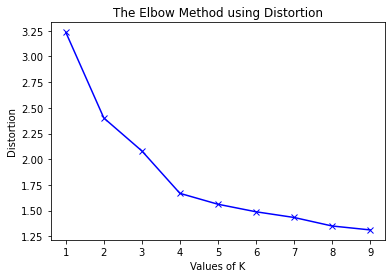

In [49]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

1 : 3726.0
2 : 1571.6870158314664
3 : 1077.4147779554687
4 : 804.1628390175849
5 : 659.2720417086596
6 : 564.8603508408071
7 : 506.25373704336187
8 : 441.1517181194817
9 : 379.77993465017477


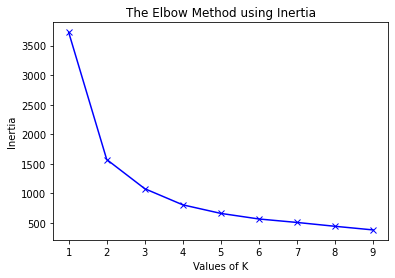

In [50]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

#### Silhouette Method

In [51]:
from sklearn.metrics import silhouette_score
for i in range(2,11):
  kmeans_ = KMeans(n_clusters=i).fit(rj_clustering)
  labels_ = kmeans_.labels_
  coef = silhouette_score(rj_clustering,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

N_cluster: 2, score: 0.7626145860710863
N_cluster: 3, score: 0.6600731625609879
N_cluster: 4, score: 0.43218496193474243
N_cluster: 5, score: 0.4227146008013998
N_cluster: 6, score: 0.37920934892800445
N_cluster: 7, score: 0.41196152148697707
N_cluster: 8, score: 0.4216726730167346
N_cluster: 9, score: 0.38052251397278913
N_cluster: 10, score: 0.3291595227799641


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


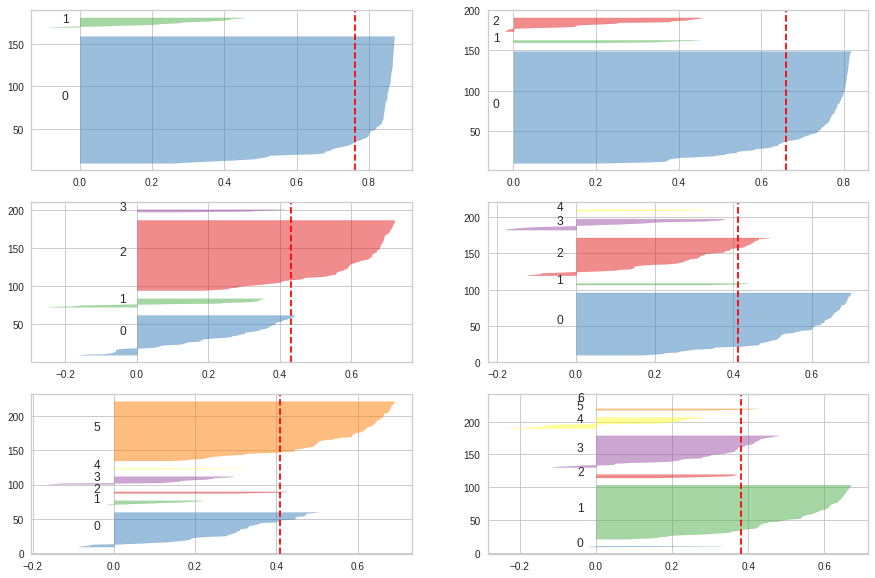

In [52]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,10))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=50, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(rj_clustering)

#### Here is the Silhouette analysis done on the above plots to select an optimal value for n_clusters.

The value of n_clusters as 5, 6 and 7 looks to be suboptimal for the given data due to the following reasons:
* Presence of clusters without low silhouette scores. 
* Wide fluctuations in the size of the silhouette plots.
The value of 4 and 5 for n_clusters looks to be the optimal one. The silhouette score for each cluster is above average silhouette scores. Also, the fluctuation in size is similar. The thickness of the silhouette plot representing each cluster also is a deciding point. For the plot with n_cluster 4 (midlle left), the thickness is more uniform than the plot with n_cluster as 2 and 3 (top) with one cluster thickness much more than the other. Thus, one can select the optimal number of clusters as 4.

### **7.2 Clustering**

In [53]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rj_clustering)
kmeans.labels_[0:10]

array([3, 3, 3, 3, 0, 0, 0, 3, 2, 1], dtype=int32)

#### Add this cluster information back into the mean table we had earlier

In [54]:
# add cluster labels
rj_grouped_cluster = rj_pop_merge.copy()
rj_grouped_cluster["Cluster"] = kmeans.labels_
print(rj_grouped_cluster.shape)
rj_grouped_cluster.head()

(162, 25)


,Neighborhood,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population,Cluster
0,ABOLICAO,299.0,250.0,3.0,16.0,76.0,113.0,124.0,74.0,78.0,41.0,20.0,4.0,0.0,38.0,47.0,464.0,9.0,191.0,132.0,0.0,174.0,43.0,12492.0,3
1,ACARI,162.0,135.0,1.0,7.0,51.0,56.0,51.0,46.0,47.0,23.0,9.0,5.0,1.0,11.0,53.0,233.0,7.0,70.0,61.0,0.0,132.0,27.0,30082.0,3
2,AGUA SANTA,137.0,116.0,4.0,7.0,31.0,53.0,47.0,43.0,27.0,19.0,21.0,1.0,0.0,15.0,21.0,217.0,3.0,76.0,60.0,0.0,94.0,20.0,9632.0,3
3,ALTO DA BOA VISTA,215.0,141.0,5.0,12.0,25.0,62.0,62.0,62.0,70.0,34.0,17.0,7.0,0.0,21.0,33.0,302.0,5.0,113.0,114.0,0.0,95.0,29.0,10277.0,3
4,ANCHIETA,657.0,582.0,13.0,36.0,182.0,296.0,281.0,200.0,134.0,62.0,32.0,3.0,0.0,60.0,104.0,1075.0,23.0,282.0,346.0,1.0,471.0,116.0,61217.0,0


#### Merge the geographical coordinates and the Label Clusters Datasets


In [55]:
covid_geo = rj_data[["Neighborhood","Latitude","Longitude"]]
rj_merged = covid_geo
rj_merged.head()

,Neighborhood,Latitude,Longitude
0,São Cristóvão,-22.899318,-43.221935
1,Benfica,-22.892297,-43.240341
2,Caju,-22.880306,-43.221494
3,Catumbi,-22.919454,-43.197081
4,Centro,-22.904393,-43.183065


In [56]:
#Remove Accent
lst = rj_merged['Neighborhood'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')    

In [57]:
rj_merged['Neighborhood'] = lst

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
rj_merged.shape

(162, 3)

In [59]:
#UPPER CASE
rj_merged['Neighborhood'] = rj_merged['Neighborhood'].str.upper()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
for i in rj_merged['Neighborhood'][0:10]:
  print(i)

SAO CRISTOVAO
BENFICA
CAJU
CATUMBI
CENTRO
CIDADE NOVA
ESTACIO
GAMBOA
LAPA
PAQUETA


In [61]:
# merge rj_grouped_cluster with covid data to add latitude/longitude for each Neighborhood
rj_merged = rj_merged.join(rj_grouped_cluster.set_index("Neighborhood"), on="Neighborhood", how='right')
print(rj_merged.shape)
rj_merged.head()

(162, 27)


,Neighborhood,Latitude,Longitude,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population,Cluster
83.0,ABOLICAO,-22.886161,-43.299846,299.0,250.0,3.0,16.0,76.0,113.0,124.0,74.0,78.0,41.0,20.0,4.0,0.0,38.0,47.0,464.0,9.0,191.0,132.0,0.0,174.0,43.0,12492.0,3
122.0,ACARI,-22.822153,-43.340674,162.0,135.0,1.0,7.0,51.0,56.0,51.0,46.0,47.0,23.0,9.0,5.0,1.0,11.0,53.0,233.0,7.0,70.0,61.0,0.0,132.0,27.0,30082.0,3
84.0,AGUA SANTA,-22.911143,-43.312126,137.0,116.0,4.0,7.0,31.0,53.0,47.0,43.0,27.0,19.0,21.0,1.0,0.0,15.0,21.0,217.0,3.0,76.0,60.0,0.0,94.0,20.0,9632.0,3
76.0,ALTO DA BOA VISTA,-22.962113,-43.253582,215.0,141.0,5.0,12.0,25.0,62.0,62.0,62.0,70.0,34.0,17.0,7.0,0.0,21.0,33.0,302.0,5.0,113.0,114.0,0.0,95.0,29.0,10277.0,3
123.0,ANCHIETA,-22.823190,-43.399107,657.0,582.0,13.0,36.0,182.0,296.0,281.0,200.0,134.0,62.0,32.0,3.0,0.0,60.0,104.0,1075.0,23.0,282.0,346.0,1.0,471.0,116.0,61217.0,0


In [62]:
rj_merged.isnull().sum()

Neighborhood    0
Latitude        6
Longitude       6
F               0
M               0
De 0 a 9        0
De 10 a 19      0
De 20 a 29      0
De 30 a 39      0
De 40 a 49      0
De 50 a 59      0
De 60 a 69      0
De 70 a 79      0
De 80 a 89      0
De 90 a 99      0
Maior de 100    0
ATIVO           0
OBITO           0
RECUPERADO      0
Amarela         0
Branca          0
Ignorado        0
Indigena        0
Parda           0
Preta           0
Population      0
Cluster         0
dtype: int64

In [63]:
#Verify the NAN values
rj_merged[rj_merged.isna().any(axis=1)]

,Neighborhood,Latitude,Longitude,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population,Cluster
NaN,CAVALCANTE,NaN,NaN,183.0,143.0,5.0,9.0,46.0,63.0,58.0,61.0,36.0,22.0,24.0,2.0,0.0,23.0,41.0,262.0,7.0,80.0,93.0,0.0,112.0,34.0,17755.0,3
NaN,FREGUESIA-ILHA,NaN,NaN,178.0,178.0,4.0,4.0,33.0,66.0,73.0,75.0,42.0,35.0,16.0,7.0,1.0,42.0,45.0,269.0,7.0,111.0,118.0,2.0,104.0,14.0,21381.0,3
NaN,FREGUESIA-JPA,NaN,NaN,1464.0,1330.0,45.0,78.0,273.0,585.0,609.0,496.0,325.0,233.0,116.0,33.0,1.0,224.0,230.0,2340.0,30.0,942.0,861.0,0.0,855.0,106.0,77562.0,0
NaN,MANGUEIRA,NaN,NaN,243.0,136.0,3.0,4.0,61.0,86.0,97.0,48.0,49.0,22.0,9.0,0.0,0.0,10.0,21.0,348.0,20.0,74.0,73.0,0.0,135.0,77.0,19619.0,3
NaN,OLARIA,NaN,NaN,982.0,838.0,17.0,40.0,235.0,390.0,356.0,321.0,229.0,146.0,67.0,19.0,0.0,84.0,138.0,1598.0,32.0,655.0,483.0,1.0,517.0,132.0,63265.0,0
NaN,RICARDO ALBUQUERQUE,NaN,NaN,260.0,220.0,7.0,15.0,70.0,92.0,95.0,83.0,64.0,36.0,15.0,3.0,0.0,28.0,48.0,404.0,17.0,115.0,130.0,0.0,184.0,34.0,32241.0,3


In [64]:
#Input Cavalcante Coordinates
rj_merged.loc[rj_merged.Neighborhood == 'CAVALCANTE','Latitude']= -22.8745414
rj_merged.loc[rj_merged.Neighborhood == 'CAVALCANTE','Longitude']= -43.3157493

In [65]:
#Input Freguesia Ilha Coordinates
rj_merged.loc[rj_merged.Neighborhood == 'FREGUESIA-ILHA','Latitude']= -22.7850602
rj_merged.loc[rj_merged.Neighborhood == 'FREGUESIA-ILHA','Longitude']= -43.1694534

In [66]:
#Input Freguesia - JPA Coordinates
rj_merged.loc[rj_merged.Neighborhood == 'FREGUESIA-JPA','Latitude']= -22.9408899
rj_merged.loc[rj_merged.Neighborhood == 'FREGUESIA-JPA','Longitude']= -43.3422564

In [67]:
#Input Mangueira Coordinates
rj_merged.loc[rj_merged.Neighborhood == 'MANGUEIRA','Latitude']= -22.9021726
rj_merged.loc[rj_merged.Neighborhood == 'MANGUEIRA','Longitude']= -43.2366933

In [68]:
#Input Olaria Coordinates
rj_merged.loc[rj_merged.Neighborhood == 'OLARIA','Latitude']= -22.1196788
rj_merged.loc[rj_merged.Neighborhood == 'OLARIA','Longitude']= -45.1340635

In [69]:
#Input Ricardo Albuquerque Coordinates
rj_merged.loc[rj_merged.Neighborhood == 'RICARDO ALBUQUERQUE','Latitude']= -22.8380924
rj_merged.loc[rj_merged.Neighborhood == 'RICARDO ALBUQUERQUE','Longitude']= -43.3963439

In [70]:
#Verify the NAN values
rj_merged[rj_merged.isna().any(axis=1)]

,Neighborhood,Latitude,Longitude,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population,Cluster


In [71]:
print(rj_merged.shape)

(162, 27)


In [72]:
#Drop ROWS with NAN values
rj_merged.dropna(axis=0, subset=['Latitude', 'Longitude'], inplace=True)

In [73]:
print(rj_merged.shape)

(162, 27)


In [74]:
# Save dataframe to csv
rj_merged.to_csv('rj_merged.csv', index = False)

In [75]:
# TO IMPORT RIO DE JANEIRO DATAFRAME WITH CLUSTER AND GEOCOORDINATES
rj_merged = pd.read_csv('rj_merged.csv', header=0)
#rj_data.dropna(subset=['Latitude'], inplace=True)
#rj_data.reset_index(drop=True, inplace=True)
rj_merged.head()

,Neighborhood,Latitude,Longitude,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population,Cluster
0,ABOLICAO,-22.886161,-43.299846,299.0,250.0,3.0,16.0,76.0,113.0,124.0,74.0,78.0,41.0,20.0,4.0,0.0,38.0,47.0,464.0,9.0,191.0,132.0,0.0,174.0,43.0,12492.0,3
1,ACARI,-22.822153,-43.340674,162.0,135.0,1.0,7.0,51.0,56.0,51.0,46.0,47.0,23.0,9.0,5.0,1.0,11.0,53.0,233.0,7.0,70.0,61.0,0.0,132.0,27.0,30082.0,3
2,AGUA SANTA,-22.911143,-43.312126,137.0,116.0,4.0,7.0,31.0,53.0,47.0,43.0,27.0,19.0,21.0,1.0,0.0,15.0,21.0,217.0,3.0,76.0,60.0,0.0,94.0,20.0,9632.0,3
3,ALTO DA BOA VISTA,-22.962113,-43.253582,215.0,141.0,5.0,12.0,25.0,62.0,62.0,62.0,70.0,34.0,17.0,7.0,0.0,21.0,33.0,302.0,5.0,113.0,114.0,0.0,95.0,29.0,10277.0,3
4,ANCHIETA,-22.823190,-43.399107,657.0,582.0,13.0,36.0,182.0,296.0,281.0,200.0,134.0,62.0,32.0,3.0,0.0,60.0,104.0,1075.0,23.0,282.0,346.0,1.0,471.0,116.0,61217.0,0


#### Just for reference, what does the cluster information look like on a map?

In [76]:
# Get the geographical coordinates of Seattle
address = 'Rio de Janeiro, RJ'

geolocator = Nominatim(user_agent="rj_explorer")
location_rio = geolocator.geocode(address)
latitude_rio = location_rio.latitude
longitude_rio = location_rio.longitude
print('The geographical coordinates of Rio de Janeiro are {}, {}.'.format(latitude_rio, longitude_rio))

The geographical coordinates of Rio de Janeiro are -22.9110137, -43.2093727.


In [77]:
# visualize the map with clusters
map_clusters = folium.Map(location=[latitude_rio, longitude_rio], zoom_start=12)

# set color scheme for the clusters

#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = {0:'red', 1:'blue', 2:'green', 3:'purple', 4:'orange'}
# add markers to the map
markers_colors = []
for lat, lon, nei, cluster in zip(rj_merged['Latitude'], rj_merged['Longitude'], rj_merged['Neighborhood'], rj_merged['Cluster']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Having the map rendered made my Jupyter lab notebook file too large to upload to Github. So, if you want to see this map, please go to the presentation or report in my Github directory.

In [78]:
#save the map as HTML file
map_clusters.save('map_clusters.html')

In [ ]:
''

## 8. Examine the clusters
Now that the AI has grouped Rio de Janeiro's Neighborhoods into clusters, I want to look deeper into each cluster. Maybe even figure out why the AI grouped the clusters the way it did and find the best cluster for me to move.
#### Let's first analyse the total covid records with the clusters.

In [85]:
# number of cases records in each cluster

rj_cluster_total = pd.DataFrame(rj_merged.groupby(["Cluster"])['ATIVO','OBITO','RECUPERADO'].sum())
#Total sum per column: 
rj_cluster_total.loc['Total',:]= rj_cluster_total.sum(axis=0)

#Total sum per row: 
rj_cluster_total.loc[:,'Total'] = rj_cluster_total.sum(axis=1)
rj_cluster_total

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,ATIVO,OBITO,RECUPERADO,Total
Cluster,,,,
0,4685.0,6582.0,75228.0,86495.0
1,2187.0,2651.0,30262.0,35100.0
2,2485.0,3779.0,45137.0,51401.0
3,2547.0,3544.0,37265.0,43356.0
Total,11904.0,16556.0,187892.0,216352.0


In [114]:
rj_cluster_total1 = pd.DataFrame(rj_merged.groupby(["Cluster"])['ATIVO','OBITO','RECUPERADO','Population'].sum())

rj_cluster_total1['%Ativo'] = rj_cluster_total1['Ativo']/rj_cluster_total1['Population']

rj_cluster_total1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


KeyError: ignored

#### How about the number of Covid records per neighborhood per cluster?

In [87]:
# number of crime records per cluster per district
rj_cluster_total2 = pd.DataFrame(rj_merged.groupby(["Cluster","Neighborhood"])['ATIVO','OBITO','RECUPERADO'].sum())
rj_cluster_total2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


ATIVO   OBITO  RECUPERADO
Cluster Neighborhood                                       
0       ANCHIETA                   60.0   104.0      1075.0
        ANDARAI                    69.0    80.0      1270.0
        ANIL                      116.0    93.0      1468.0
        BENFICA                    40.0    71.0       942.0
        BENTO RIBEIRO              82.0   121.0       968.0
        BONSUCESSO                 73.0   122.0      2554.0
        BRAS DE PINA               96.0   163.0      1245.0
        CACHAMBI                   97.0   122.0      1642.0
        CORDOVIL                   53.0    88.0       907.0
        COSMOS                     65.0   146.0      1124.0
        CURICICA                   74.0    87.0       970.0
        ENGENHO DE DENTRO         116.0   164.0      1821.0
        ENGENHO NOVO               99.0    94.0      1547.0
        FLAMENGO                  163.0   144.0      2787.0
        FREGUESIA-JPA             224.0   230.0      2340.0
        GAVEA                      91.0    79.0      1354.0
        GRAJAU                     72.0   109.0      1579.0
        GUADALUPE                  72.0   158.0      1084.0
        GUARATIBA                 106.0   241.0      1491.0
        INHAUMA                   116.0   133.0      1750.0
        INHOAIBA                   70.0   147.0       956.0
        IPANEMA                   233.0   179.0      2263.0
        JACARE                     43.0    45.0       957.0
        JARDIM BOTANICO            83.0    31.0      1103.0
        JARDIM GUANABARA           89.0    73.0       998.0
        LAGOA                      82.0    52.0      1198.0
        LARANJEIRAS               125.0   138.0      1916.0
        LINS DE VASCONCELOS        90.0    95.0       882.0
        MADUREIRA                  59.0   133.0      1060.0
        MARACANA                   37.0    79.0      1336.0
        MARE                       90.0   125.0      1813.0
        MARECHAL HERMES            73.0   144.0       965.0
        MEIER                     174.0   152.0      2659.0
        OLARIA                     84.0   138.0      1598.0
        PADRE MIGUEL               51.0   222.0      1047.0
        PAVUNA                     98.0   175.0      1406.0
        PECHINCHA                 137.0   123.0      1569.0
        PENHA                     108.0   137.0      1735.0
        PENHA CIRCULAR             69.0    84.0       984.0
        PIEDADE                    76.0   122.0      1426.0
        PILARES                    54.0    82.0       930.0
        PRACA SECA                126.0   174.0      1455.0
        RAMOS                      87.0   122.0      2463.0
        RIO COMPRIDO               82.0   126.0      1587.0
        ROCHA MIRANDA              73.0   162.0       840.0
        ROCINHA                    43.0    45.0      1217.0
        SANTA TERESA               85.0   108.0      1097.0
        SANTISSIMO                 52.0   116.0      1043.0
        SAO CRISTOVAO              58.0    97.0      1453.0
        SENADOR CAMARA             56.0   241.0      1435.0
        SEPETIBA                   52.0   140.0      1751.0
        TANQUE                     69.0   110.0       988.0
        VILA VALQUEIRE             93.0   116.0      1180.0
1       BARRA DA TIJUCA           674.0   422.0      8648.0
        CAMPO GRANDE              423.0  1037.0      6947.0
        COPACABANA                690.0   577.0      6691.0
        TIJUCA                    400.0   615.0      7976.0
2       BANGU                     199.0   693.0      3857.0
        BOTAFOGO                  284.0   203.0      4897.0
        CENTRO                    110.0   139.0      3408.0
        IRAJA                     149.0   258.0      2509.0
        JACAREPAGUA               302.0   265.0      4516.0
        LEBLON                    246.0   146.0      2848.0
        PACIENCIA                  71.0   222.0      2813.0
        REALENGO                  153.0   552.0      3182.0
        RECREI

### Cluster 0

### Analysis of the sociological profile of cluster 0

In [89]:
# Analysis of the sociological profile of cluster 0
rj_cluster0 = rj_merged.loc[rj_merged['Cluster'] == 0]

rj_cluster0.set_index(['Neighborhood','Latitude','Longitude', 'Cluster'])
columns= ['F', 'M',	'De 0 a 9',	'De 10 a 19',	'De 20 a 29',	'De 30 a 39',	'De 40 a 49',	
          'De 50 a 59',	'De 60 a 69',	'De 70 a 79',	'De 80 a 89',	'De 90 a 99',	
          'Maior de 100', 'ATIVO', 'OBITO',	'RECUPERADO',	'Amarela', 'Branca',	
          'Ignorado',	'Indigena',	'Parda',	'Preta']
#Total sum per column: 
#rj_cluster0.loc['Total',columns]= rj_cluster0.sum(axis=0)

#Total sum per row: 
#rj_cluster0.loc[:,'Total'] = rj_cluster0.sum(axis=1)
rj_cluster0.sort_values(by=['M','De 30 a 39','Parda']).head(10)


,Neighborhood,Latitude,Longitude,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population,Cluster
71,JACARE,-22.893117,-43.257200,621.0,424.0,14.0,35.0,181.0,199.0,196.0,167.0,159.0,62.0,27.0,4.0,1.0,43.0,45.0,957.0,32.0,302.0,98.0,0.0,441.0,172.0,10204.0,0
110,PILARES,-22.879090,-43.295548,609.0,457.0,25.0,35.0,146.0,214.0,210.0,191.0,134.0,61.0,43.0,7.0,0.0,54.0,82.0,930.0,17.0,348.0,233.0,1.0,363.0,104.0,29975.0,0
85,LINS DE VASCONCELOS,-22.914051,-43.284353,604.0,463.0,13.0,48.0,130.0,203.0,219.0,186.0,131.0,77.0,44.0,15.0,1.0,90.0,95.0,882.0,16.0,326.0,334.0,0.0,278.0,113.0,41236.0,0
12,BENFICA,-22.892297,-43.240341,584.0,469.0,15.0,40.0,174.0,253.0,218.0,165.0,95.0,51.0,36.0,6.0,0.0,40.0,71.0,942.0,35.0,320.0,198.0,0.0,365.0,135.0,27589.0,0
37,CORDOVIL,-22.819438,-43.291591,560.0,488.0,9.0,30.0,150.0,225.0,212.0,165.0,134.0,71.0,41.0,11.0,0.0,53.0,88.0,907.0,28.0,283.0,198.0,0.0,424.0,115.0,49722.0,0
126,ROCINHA,-22.988520,-43.248206,808.0,497.0,25.0,60.0,228.0,286.0,275.0,244.0,136.0,37.0,11.0,3.0,0.0,43.0,45.0,1217.0,43.0,355.0,272.0,1.0,554.0,80.0,76292.0,0
108,PENHA CIRCULAR,-22.832642,-43.284223,633.0,504.0,12.0,33.0,166.0,231.0,212.0,198.0,154.0,72.0,47.0,11.0,1.0,69.0,84.0,984.0,29.0,320.0,264.0,0.0,409.0,115.0,52598.0,0
139,TANQUE,-22.915193,-43.355747,663.0,504.0,16.0,41.0,180.0,237.0,239.0,180.0,123.0,91.0,45.0,15.0,0.0,69.0,110.0,988.0,21.0,313.0,305.0,1.0,444.0,83.0,41642.0,0
125,ROCHA MIRANDA,-22.850347,-43.346305,550.0,525.0,12.0,22.0,126.0,235.0,235.0,154.0,136.0,85.0,60.0,10.0,0.0,73.0,162.0,840.0,20.0,301.0,305.0,0.0,358.0,91.0,48607.0,0
13,BENTO RIBEIRO,-22.866661,-43.360837,642.0,529.0,8.0,28.0,161.0,252.0,231.0,184.0,127.0,96.0,70.0,14.0,0.0,82.0,121.0,968.0,24.0,343.0,339.0,0.0,370.0,95.0,48078.0,0


<BarContainer object of 6 artists>

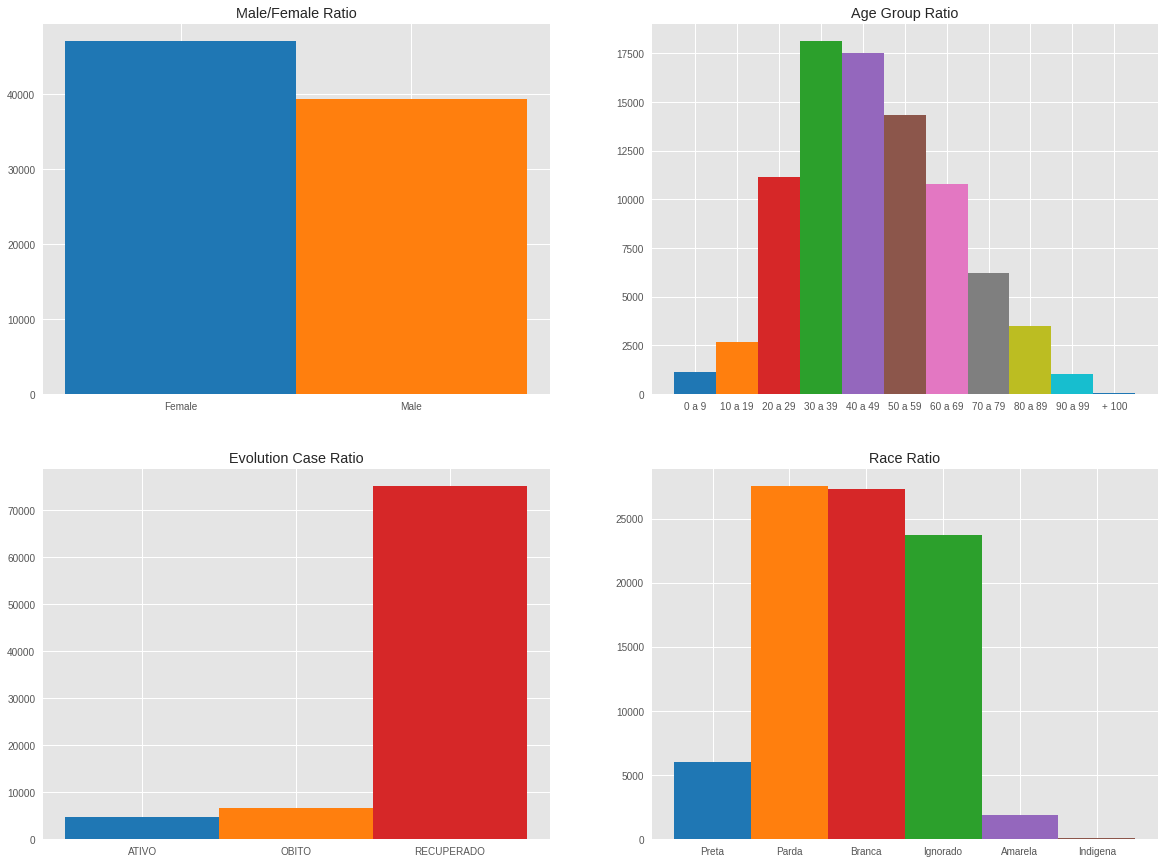

In [92]:
# Cluster 0 Plots

plt.style.use('ggplot')
fig, axs  = plt.subplots(2,2, figsize=(20,15))

#Sex Ratio Plot
axs[0, 0].set_title('Male/Female Ratio')
axs[0, 0].bar(np.arange(2), [rj_cluster0['F'].sum(), rj_cluster0['M'].sum()], 
              color=['tab:blue', 'tab:orange'], 
              width=1,
              tick_label=['Female', 'Male'], 
              align='center')


#Age Group Ratio Plot
#age_label=['0 a 9','10 a 19','20 a 29','30 a 39','40 a 49',
#          '50 a 59','60 a 69','70 a 79','80 a 89','90 a 99','+ 100']
#axs[0, 1].set_xticklabels(age_label, fontsize=12, rotation=45, ha='right')
axs[0, 1].set_title('Age Group Ratio')
axs[0, 1].bar(np.arange(11), [rj_cluster0['De 0 a 9'].sum(), rj_cluster0['De 10 a 19'].sum(), 
                 rj_cluster0['De 20 a 29'].sum(), rj_cluster0['De 30 a 39'].sum(), 
                 rj_cluster0['De 40 a 49'].sum(), rj_cluster0['De 50 a 59'].sum(),
                 rj_cluster0['De 60 a 69'].sum(), rj_cluster0['De 70 a 79'].sum(), 
                 rj_cluster0['De 80 a 89'].sum(), rj_cluster0['De 90 a 99'].sum(), 
                 rj_cluster0['Maior de 100'].sum()],
              tick_label=['0 a 9','10 a 19','20 a 29','30 a 39','40 a 49',
                       '50 a 59','60 a 69','70 a 79','80 a 89','90 a 99','+ 100'], 
              width=1, 
              color=['tab:blue', 'tab:orange','tab:red','tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'],
              align='center')


#Evolution Case Ratio Plot
axs[1, 0].set_title('Evolution Case Ratio')
axs[1, 0].bar(np.arange(3), [rj_cluster0['ATIVO'].sum(), rj_cluster0['OBITO'].sum(), 
                 rj_cluster0['RECUPERADO'].sum()], 
              width=1,
              tick_label=['ATIVO', 'OBITO', 'RECUPERADO'],
              color=['tab:blue', 'tab:orange','tab:red'], 
              align='center')


#Race Ratio Plot
axs[1, 1].set_title('Race Ratio')
axs[1, 1].bar(np.arange(6), [rj_cluster0['Preta'].sum(), rj_cluster0['Parda'].sum(), 
                 rj_cluster0['Branca'].sum(), rj_cluster0['Ignorado'].sum(), 
                 rj_cluster0['Amarela'].sum(), rj_cluster0['Indigena'].sum()], 
              width=1,
              tick_label=['Preta', 'Parda', 'Branca', 'Ignorado', 
                            'Amarela', 'Indigena'],
              color=['tab:blue', 'tab:orange','tab:red','tab:green', 'tab:purple', 'tab:brown'], 
              align='center')

### Cluster 1

In [90]:
# Analysis of the sociological profile of cluster 0
rj_cluster1 = rj_merged.loc[rj_merged['Cluster'] == 1]

rj_cluster1.set_index(['Neighborhood','Latitude','Longitude', 'Cluster'])
columns= ['F', 'M',	'De 0 a 9',	'De 10 a 19',	'De 20 a 29',	'De 30 a 39',	'De 40 a 49',	
          'De 50 a 59',	'De 60 a 69',	'De 70 a 79',	'De 80 a 89',	'De 90 a 99',	
          'Maior de 100', 'ATIVO', 'OBITO',	'RECUPERADO',	'Amarela', 'Branca',	
          'Ignorado',	'Indigena',	'Parda',	'Preta']
#Total sum per column: 
#rj_cluster0.loc['Total',columns]= rj_cluster0.sum(axis=0)

#Total sum per row: 
#rj_cluster0.loc[:,'Total'] = rj_cluster0.sum(axis=1)
rj_cluster1.sort_values(by=['M','De 30 a 39','Parda']).head(10)

,Neighborhood,Latitude,Longitude,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population,Cluster
36,COPACABANA,-22.971964,-43.184343,4207.0,3751.0,61.0,134.0,780.0,1530.0,1264.0,1165.0,1192.0,902.0,630.0,290.0,10.0,690.0,577.0,6691.0,105.0,3068.0,3171.0,4.0,1380.0,230.0,161031.0,1
142,TIJUCA,-22.933216,-43.238145,4899.0,4092.0,131.0,228.0,950.0,1641.0,1637.0,1539.0,1266.0,824.0,555.0,211.0,9.0,400.0,615.0,7976.0,126.0,3242.0,3819.0,3.0,1501.0,300.0,180186.0,1
23,CAMPO GRANDE,-22.902953,-43.559129,4311.0,4096.0,95.0,214.0,969.0,1873.0,1788.0,1427.0,1025.0,662.0,292.0,61.0,1.0,423.0,1037.0,6947.0,215.0,2084.0,2168.0,7.0,3405.0,528.0,361207.0,1
9,BARRA DA TIJUCA,-22.999740,-43.365993,4780.0,4964.0,140.0,399.0,1024.0,1797.0,2127.0,1625.0,1311.0,804.0,397.0,117.0,3.0,674.0,422.0,8648.0,85.0,3132.0,4990.0,6.0,1403.0,128.0,149516.0,1


<BarContainer object of 6 artists>

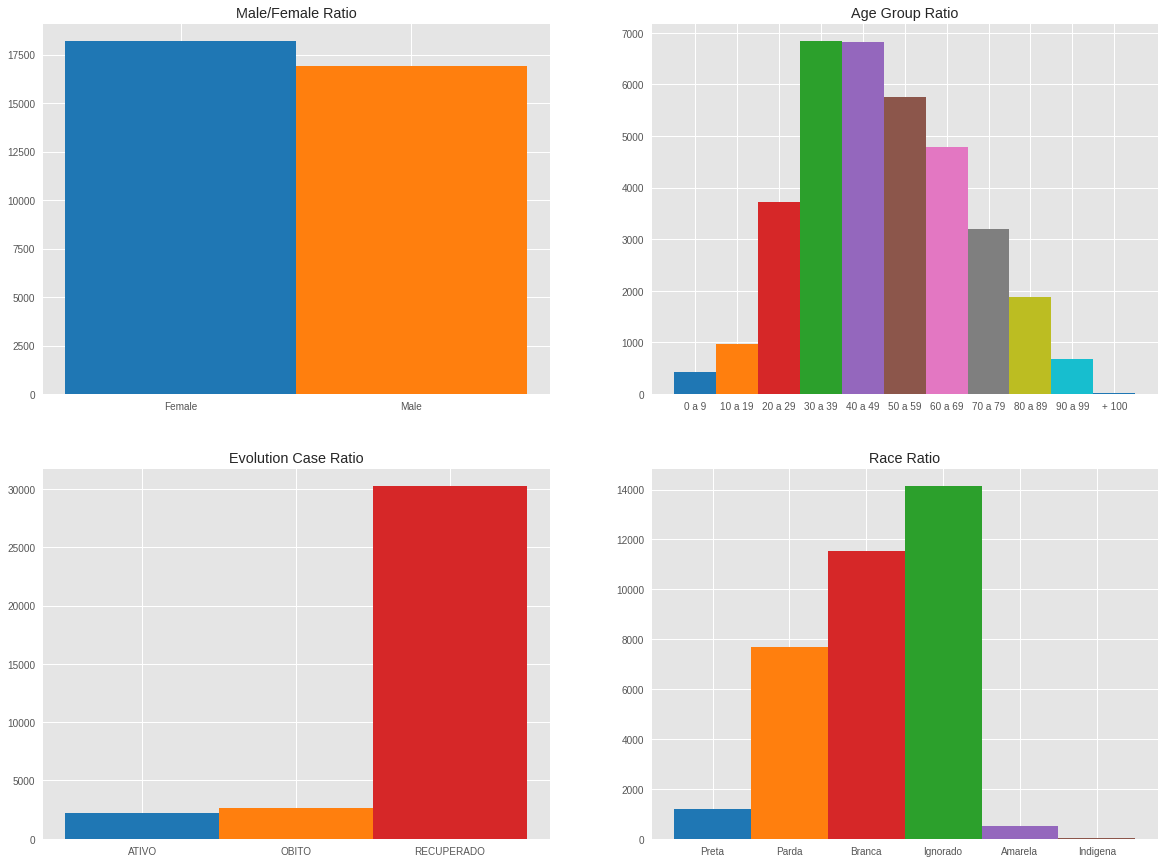

In [91]:
# Cluster 1 Plots

plt.style.use('ggplot')
fig, axs  = plt.subplots(2,2, figsize=(20,15))

#Sex Ratio Plot
axs[0, 0].set_title('Male/Female Ratio')
axs[0, 0].bar(np.arange(2), [rj_cluster1['F'].sum(), rj_cluster1['M'].sum()], 
              color=['tab:blue', 'tab:orange'], 
              width=1,
              tick_label=['Female', 'Male'], 
              align='center')


#Age Group Ratio Plot
#age_label=['0 a 9','10 a 19','20 a 29','30 a 39','40 a 49',
#          '50 a 59','60 a 69','70 a 79','80 a 89','90 a 99','+ 100']
#axs[0, 1].set_xticklabels(age_label, fontsize=12, rotation=45, ha='right')
axs[0, 1].set_title('Age Group Ratio')
axs[0, 1].bar(np.arange(11), [rj_cluster1['De 0 a 9'].sum(), rj_cluster1['De 10 a 19'].sum(), 
                 rj_cluster1['De 20 a 29'].sum(), rj_cluster1['De 30 a 39'].sum(), 
                 rj_cluster1['De 40 a 49'].sum(), rj_cluster1['De 50 a 59'].sum(),
                 rj_cluster1['De 60 a 69'].sum(), rj_cluster1['De 70 a 79'].sum(), 
                 rj_cluster1['De 80 a 89'].sum(), rj_cluster1['De 90 a 99'].sum(), 
                 rj_cluster1['Maior de 100'].sum()],
              tick_label=['0 a 9','10 a 19','20 a 29','30 a 39','40 a 49',
                       '50 a 59','60 a 69','70 a 79','80 a 89','90 a 99','+ 100'], 
              width=1, 
              color=['tab:blue', 'tab:orange','tab:red','tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'],
              align='center')


#Evolution Case Ratio Plot
axs[1, 0].set_title('Evolution Case Ratio')
axs[1, 0].bar(np.arange(3), [rj_cluster1['ATIVO'].sum(), rj_cluster1['OBITO'].sum(), 
                 rj_cluster1['RECUPERADO'].sum()], 
              width=1,
              tick_label=['ATIVO', 'OBITO', 'RECUPERADO'],
              color=['tab:blue', 'tab:orange','tab:red'], 
              align='center')


#Race Ratio Plot
axs[1, 1].set_title('Race Ratio')
axs[1, 1].bar(np.arange(6), [rj_cluster1['Preta'].sum(), rj_cluster1['Parda'].sum(), 
                 rj_cluster1['Branca'].sum(), rj_cluster1['Ignorado'].sum(), 
                 rj_cluster1['Amarela'].sum(), rj_cluster1['Indigena'].sum()], 
              width=1,
              tick_label=['Preta', 'Parda', 'Branca', 'Ignorado', 
                            'Amarela', 'Indigena'],
              color=['tab:blue', 'tab:orange','tab:red','tab:green', 'tab:purple', 'tab:brown'], 
              align='center')

### Cluster 2

In [93]:
# Analysis of the sociological profile of cluster 0
rj_cluster2 = rj_merged.loc[rj_merged['Cluster'] == 2]

rj_cluster2.set_index(['Neighborhood','Latitude','Longitude', 'Cluster'])
columns= ['F', 'M',	'De 0 a 9',	'De 10 a 19',	'De 20 a 29',	'De 30 a 39',	'De 40 a 49',	
          'De 50 a 59',	'De 60 a 69',	'De 70 a 79',	'De 80 a 89',	'De 90 a 99',	
          'Maior de 100', 'ATIVO', 'OBITO',	'RECUPERADO',	'Amarela', 'Branca',	
          'Ignorado',	'Indigena',	'Parda',	'Preta']
#Total sum per column: 
#rj_cluster0.loc['Total',columns]= rj_cluster0.sum(axis=0)

#Total sum per row: 
#rj_cluster0.loc[:,'Total'] = rj_cluster0.sum(axis=1)
rj_cluster2.sort_values(by=['M','De 30 a 39','Parda']).head(10)

,Neighborhood,Latitude,Longitude,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population,Cluster
69,IRAJA,-22.835113,-43.323362,1567.0,1349.0,24.0,70.0,363.0,635.0,638.0,466.0,355.0,227.0,101.0,35.0,2.0,149.0,258.0,2509.0,65.0,925.0,725.0,4.0,1010.0,187.0,106020.0,2
98,PACIENCIA,-22.898700,-43.636956,1658.0,1448.0,47.0,122.0,470.0,686.0,661.0,504.0,369.0,181.0,52.0,13.0,1.0,71.0,222.0,2813.0,89.0,737.0,697.0,1.0,1258.0,324.0,104089.0,2
155,VILA ISABEL,-22.915222,-43.247263,1987.0,1491.0,48.0,100.0,419.0,717.0,653.0,547.0,439.0,269.0,201.0,59.0,26.0,139.0,228.0,3111.0,59.0,1233.0,1309.0,0.0,688.0,189.0,94620.0,2
83,LEBLON,-22.983556,-43.224938,1676.0,1564.0,62.0,132.0,313.0,546.0,579.0,492.0,492.0,331.0,219.0,70.0,4.0,246.0,146.0,2848.0,40.0,1203.0,1343.0,1.0,523.0,130.0,50648.0,2
118,REALENGO,-22.877274,-43.430103,2061.0,1826.0,63.0,86.0,464.0,802.0,771.0,638.0,500.0,347.0,171.0,44.0,1.0,153.0,552.0,3182.0,120.0,1001.0,862.0,2.0,1578.0,324.0,198135.0,2
28,CENTRO,-22.904393,-43.183065,1651.0,2006.0,37.0,70.0,466.0,941.0,828.0,570.0,418.0,211.0,103.0,13.0,0.0,110.0,139.0,3408.0,148.0,1233.0,1222.0,3.0,855.0,196.0,45256.0,2
140,TAQUARA,-22.921886,-43.384646,2397.0,2087.0,67.0,132.0,594.0,969.0,903.0,755.0,544.0,301.0,163.0,53.0,3.0,332.0,357.0,3795.0,52.0,1348.0,1567.0,2.0,1288.0,227.0,112339.0,2
8,BANGU,-22.875305,-43.464880,2487.0,2262.0,73.0,93.0,563.0,992.0,911.0,854.0,616.0,405.0,189.0,49.0,4.0,199.0,693.0,3857.0,131.0,1144.0,1153.0,4.0,1902.0,415.0,267438.0,2
72,JACAREPAGUA,-22.966504,-43.371319,2662.0,2421.0,71.0,131.0,599.0,1297.0,1170.0,814.0,552.0,290.0,125.0,32.0,2.0,302.0,265.0,4516.0,96.0,1634.0,1726.0,1.0,1389.0,237.0,173059.0,2
15,BOTAFOGO,-22.948845,-43.179829,2852.0,2532.0,87.0,162.0,628.0,1247.0,1094.0,807.0,648.0,387.0,222.0,94.0,8.0,284.0,203.0,4897.0,61.0,1896.0,2464.0,3.0,839.0,121.0,91179.0,2


<BarContainer object of 6 artists>

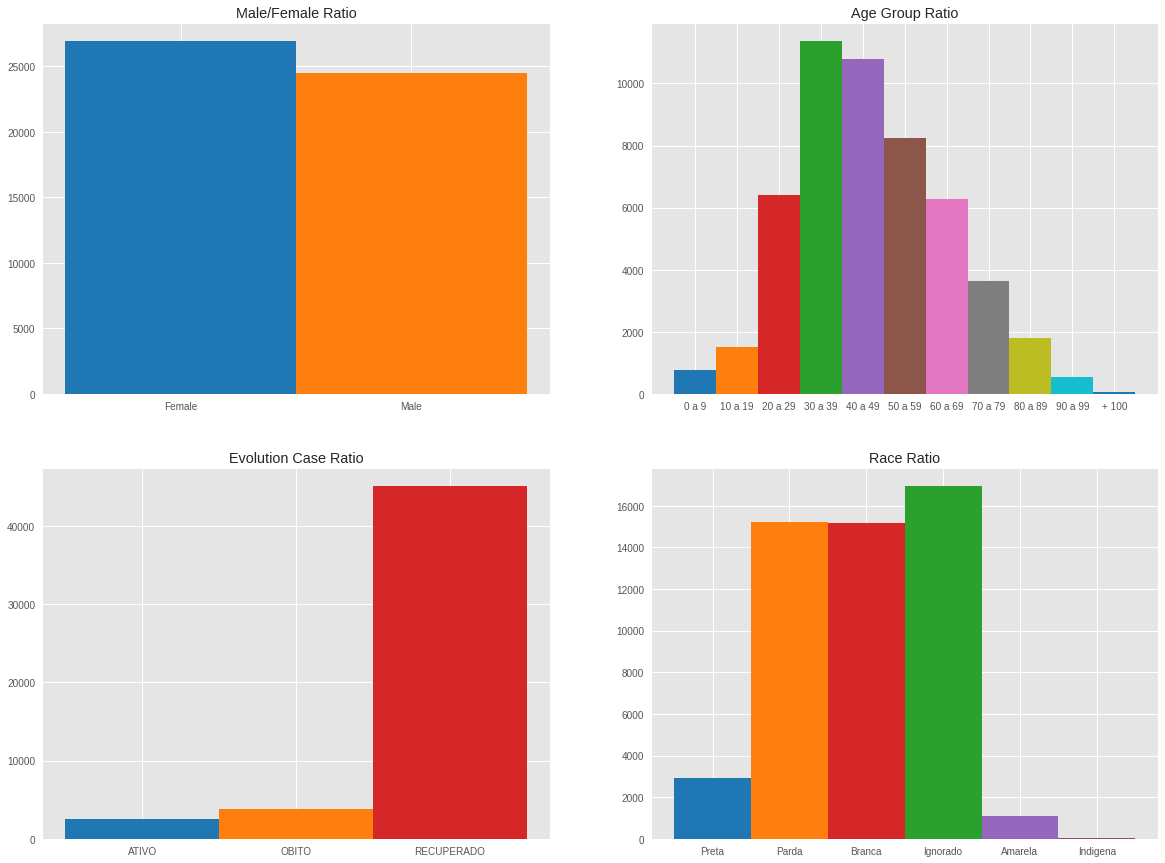

In [94]:
# Cluster 2 Plots

plt.style.use('ggplot')
fig, axs  = plt.subplots(2,2, figsize=(20,15))

#Sex Ratio Plot
axs[0, 0].set_title('Male/Female Ratio')
axs[0, 0].bar(np.arange(2), [rj_cluster2['F'].sum(), rj_cluster2['M'].sum()], 
              color=['tab:blue', 'tab:orange'], 
              width=1,
              tick_label=['Female', 'Male'], 
              align='center')


#Age Group Ratio Plot
#age_label=['0 a 9','10 a 19','20 a 29','30 a 39','40 a 49',
#          '50 a 59','60 a 69','70 a 79','80 a 89','90 a 99','+ 100']
#axs[0, 1].set_xticklabels(age_label, fontsize=12, rotation=45, ha='right')
axs[0, 1].set_title('Age Group Ratio')
axs[0, 1].bar(np.arange(11), [rj_cluster2['De 0 a 9'].sum(), rj_cluster2['De 10 a 19'].sum(), 
                 rj_cluster2['De 20 a 29'].sum(), rj_cluster2['De 30 a 39'].sum(), 
                 rj_cluster2['De 40 a 49'].sum(), rj_cluster2['De 50 a 59'].sum(),
                 rj_cluster2['De 60 a 69'].sum(), rj_cluster2['De 70 a 79'].sum(), 
                 rj_cluster2['De 80 a 89'].sum(), rj_cluster2['De 90 a 99'].sum(), 
                 rj_cluster2['Maior de 100'].sum()],
              tick_label=['0 a 9','10 a 19','20 a 29','30 a 39','40 a 49',
                       '50 a 59','60 a 69','70 a 79','80 a 89','90 a 99','+ 100'], 
              width=1, 
              color=['tab:blue', 'tab:orange','tab:red','tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'],
              align='center')


#Evolution Case Ratio Plot
axs[1, 0].set_title('Evolution Case Ratio')
axs[1, 0].bar(np.arange(3), [rj_cluster2['ATIVO'].sum(), rj_cluster2['OBITO'].sum(), 
                 rj_cluster2['RECUPERADO'].sum()], 
              width=1,
              tick_label=['ATIVO', 'OBITO', 'RECUPERADO'],
              color=['tab:blue', 'tab:orange','tab:red'], 
              align='center')


#Race Ratio Plot
axs[1, 1].set_title('Race Ratio')
axs[1, 1].bar(np.arange(6), [rj_cluster2['Preta'].sum(), rj_cluster2['Parda'].sum(), 
                 rj_cluster2['Branca'].sum(), rj_cluster2['Ignorado'].sum(), 
                 rj_cluster2['Amarela'].sum(), rj_cluster2['Indigena'].sum()], 
              width=1,
              tick_label=['Preta', 'Parda', 'Branca', 'Ignorado', 
                            'Amarela', 'Indigena'],
              color=['tab:blue', 'tab:orange','tab:red','tab:green', 'tab:purple', 'tab:brown'], 
              align='center')


### Cluster 3

In [95]:
# Analysis of the sociological profile of cluster 0
rj_cluster3 = rj_merged.loc[rj_merged['Cluster'] == 3]

rj_cluster3.set_index(['Neighborhood','Latitude','Longitude', 'Cluster'])
columns= ['F', 'M',	'De 0 a 9',	'De 10 a 19',	'De 20 a 29',	'De 30 a 39',	'De 40 a 49',	
          'De 50 a 59',	'De 60 a 69',	'De 70 a 79',	'De 80 a 89',	'De 90 a 99',	
          'Maior de 100', 'ATIVO', 'OBITO',	'RECUPERADO',	'Amarela', 'Branca',	
          'Ignorado',	'Indigena',	'Parda',	'Preta']
#Total sum per column: 
#rj_cluster0.loc['Total',columns]= rj_cluster0.sum(axis=0)

#Total sum per row: 
#rj_cluster0.loc[:,'Total'] = rj_cluster0.sum(axis=1)
rj_cluster0.sort_values(by=['M','De 30 a 39','Parda']).head(10)

,Neighborhood,Latitude,Longitude,F,M,De 0 a 9,De 10 a 19,De 20 a 29,De 30 a 39,De 40 a 49,De 50 a 59,De 60 a 69,De 70 a 79,De 80 a 89,De 90 a 99,Maior de 100,ATIVO,OBITO,RECUPERADO,Amarela,Branca,Ignorado,Indigena,Parda,Preta,Population,Cluster
71,JACARE,-22.893117,-43.257200,621.0,424.0,14.0,35.0,181.0,199.0,196.0,167.0,159.0,62.0,27.0,4.0,1.0,43.0,45.0,957.0,32.0,302.0,98.0,0.0,441.0,172.0,10204.0,0
110,PILARES,-22.879090,-43.295548,609.0,457.0,25.0,35.0,146.0,214.0,210.0,191.0,134.0,61.0,43.0,7.0,0.0,54.0,82.0,930.0,17.0,348.0,233.0,1.0,363.0,104.0,29975.0,0
85,LINS DE VASCONCELOS,-22.914051,-43.284353,604.0,463.0,13.0,48.0,130.0,203.0,219.0,186.0,131.0,77.0,44.0,15.0,1.0,90.0,95.0,882.0,16.0,326.0,334.0,0.0,278.0,113.0,41236.0,0
12,BENFICA,-22.892297,-43.240341,584.0,469.0,15.0,40.0,174.0,253.0,218.0,165.0,95.0,51.0,36.0,6.0,0.0,40.0,71.0,942.0,35.0,320.0,198.0,0.0,365.0,135.0,27589.0,0
37,CORDOVIL,-22.819438,-43.291591,560.0,488.0,9.0,30.0,150.0,225.0,212.0,165.0,134.0,71.0,41.0,11.0,0.0,53.0,88.0,907.0,28.0,283.0,198.0,0.0,424.0,115.0,49722.0,0
126,ROCINHA,-22.988520,-43.248206,808.0,497.0,25.0,60.0,228.0,286.0,275.0,244.0,136.0,37.0,11.0,3.0,0.0,43.0,45.0,1217.0,43.0,355.0,272.0,1.0,554.0,80.0,76292.0,0
108,PENHA CIRCULAR,-22.832642,-43.284223,633.0,504.0,12.0,33.0,166.0,231.0,212.0,198.0,154.0,72.0,47.0,11.0,1.0,69.0,84.0,984.0,29.0,320.0,264.0,0.0,409.0,115.0,52598.0,0
139,TANQUE,-22.915193,-43.355747,663.0,504.0,16.0,41.0,180.0,237.0,239.0,180.0,123.0,91.0,45.0,15.0,0.0,69.0,110.0,988.0,21.0,313.0,305.0,1.0,444.0,83.0,41642.0,0
125,ROCHA MIRANDA,-22.850347,-43.346305,550.0,525.0,12.0,22.0,126.0,235.0,235.0,154.0,136.0,85.0,60.0,10.0,0.0,73.0,162.0,840.0,20.0,301.0,305.0,0.0,358.0,91.0,48607.0,0
13,BENTO RIBEIRO,-22.866661,-43.360837,642.0,529.0,8.0,28.0,161.0,252.0,231.0,184.0,127.0,96.0,70.0,14.0,0.0,82.0,121.0,968.0,24.0,343.0,339.0,0.0,370.0,95.0,48078.0,0


<BarContainer object of 6 artists>

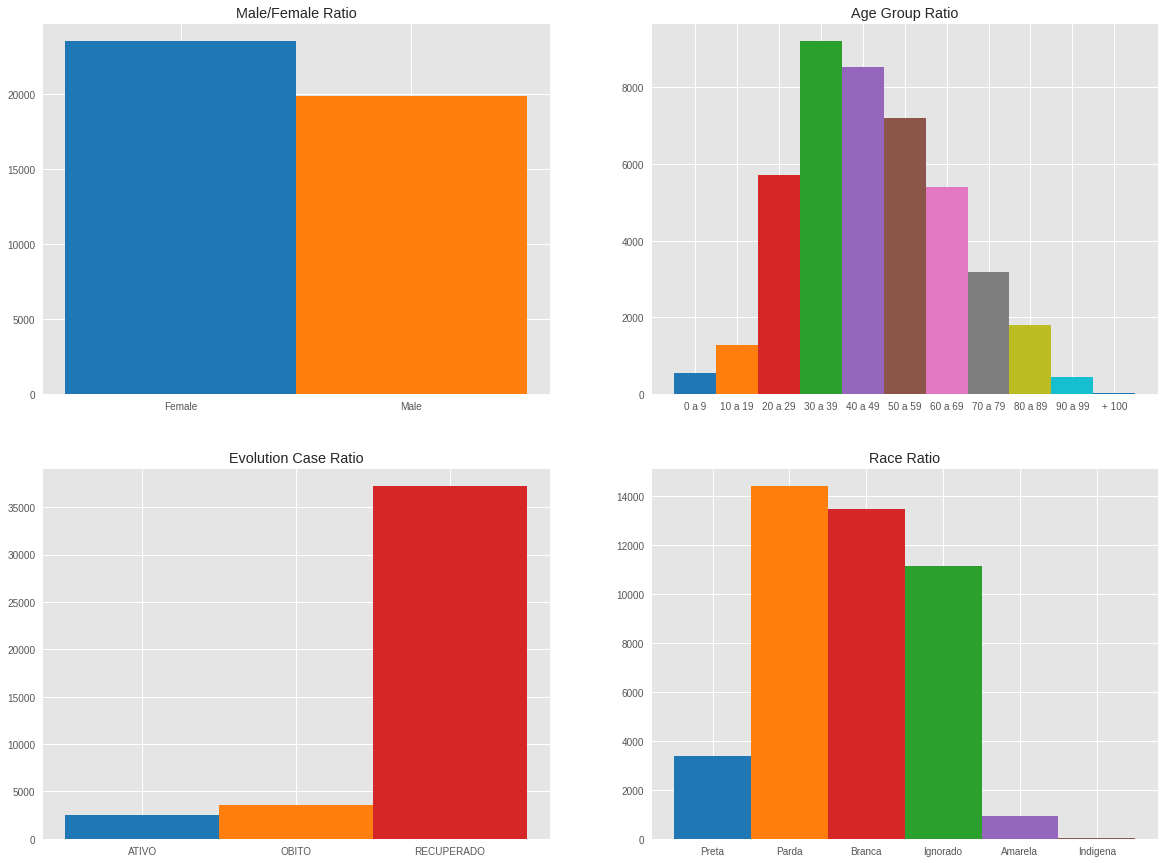

In [96]:
# Cluster 3 Plots

plt.style.use('ggplot')
fig, axs  = plt.subplots(2,2, figsize=(20,15))

#Sex Ratio Plot
axs[0, 0].set_title('Male/Female Ratio')
axs[0, 0].bar(np.arange(2), [rj_cluster3['F'].sum(), rj_cluster3['M'].sum()], 
              color=['tab:blue', 'tab:orange'], 
              width=1,
              tick_label=['Female', 'Male'], 
              align='center')


#Age Group Ratio Plot
#age_label=['0 a 9','10 a 19','20 a 29','30 a 39','40 a 49',
#          '50 a 59','60 a 69','70 a 79','80 a 89','90 a 99','+ 100']
#axs[0, 1].set_xticklabels(age_label, fontsize=12, rotation=45, ha='right')
axs[0, 1].set_title('Age Group Ratio')
axs[0, 1].bar(np.arange(11), [rj_cluster3['De 0 a 9'].sum(), rj_cluster3['De 10 a 19'].sum(), 
                 rj_cluster3['De 20 a 29'].sum(), rj_cluster3['De 30 a 39'].sum(), 
                 rj_cluster3['De 40 a 49'].sum(), rj_cluster3['De 50 a 59'].sum(),
                 rj_cluster3['De 60 a 69'].sum(), rj_cluster3['De 70 a 79'].sum(), 
                 rj_cluster3['De 80 a 89'].sum(), rj_cluster3['De 90 a 99'].sum(), 
                 rj_cluster3['Maior de 100'].sum()],
              tick_label=['0 a 9','10 a 19','20 a 29','30 a 39','40 a 49',
                       '50 a 59','60 a 69','70 a 79','80 a 89','90 a 99','+ 100'], 
              width=1, 
              color=['tab:blue', 'tab:orange','tab:red','tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'],
              align='center')


#Evolution Case Ratio Plot
axs[1, 0].set_title('Evolution Case Ratio')
axs[1, 0].bar(np.arange(3), [rj_cluster3['ATIVO'].sum(), rj_cluster3['OBITO'].sum(), 
                 rj_cluster3['RECUPERADO'].sum()], 
              width=1,
              tick_label=['ATIVO', 'OBITO', 'RECUPERADO'],
              color=['tab:blue', 'tab:orange','tab:red'], 
              align='center')


#Race Ratio Plot
axs[1, 1].set_title('Race Ratio')
axs[1, 1].bar(np.arange(6), [rj_cluster3['Preta'].sum(), rj_cluster3['Parda'].sum(), 
                 rj_cluster3['Branca'].sum(), rj_cluster3['Ignorado'].sum(), 
                 rj_cluster3['Amarela'].sum(), rj_cluster3['Indigena'].sum()], 
              width=1,
              tick_label=['Preta', 'Parda', 'Branca', 'Ignorado', 
                            'Amarela', 'Indigena'],
              color=['tab:blue', 'tab:orange','tab:red','tab:green', 'tab:purple', 'tab:brown'], 
              align='center')

### Cluster 4

#### Since Clusters 0, 1, and 2 contain districts that are in the list of top 10 districts with the most total crimes, and Cluster 4 only contains commercial districts (not districts for living in), this narrows down our search for a suitable place to live to just Cluster 3. 

## 9. Explore the neighborhoods with healthy services in Rio de Janeiro


First we will get all healthy venues that are within the neighborhoods in Rio de Janeiro, along with their coordinates, and put them into a pandas dataframe. Districts that don't have any neighborhoods will have the district name be the neighborhood name.

In [115]:
rj_foursquare = pd.read_csv('rio-rj-neighborhoods-geo.csv', header=0)
#rj_data.dropna(subset=['Latitude'], inplace=True)
#rj_data.reset_index(drop=True, inplace=True)
rj_foursquare.head()

,City,Zone,District,Neighborhood,Latitude,Longitude
0,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,São Cristóvão,-22.899318,-43.221935
1,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Benfica,-22.892297,-43.240341
2,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Caju,-22.880306,-43.221494
3,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Catumbi,-22.919454,-43.197081
4,Rio de Janeiro,Central,Centro Histórico e Zona Portuária,Centro,-22.904393,-43.183065


### Now that have a dataframe containing all the neighborhoods, we want to look at the venues nearby them.

#### Define Foursquare credentials and version

In [165]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


#### Define a function that gets the top 100 venues within a radius of 2000 meters.

In [143]:
def getNearbyVenues(names, latitudes, longitudes, categories, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng, cat in zip(names, latitudes, longitudes, categories):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat,
            lng,
            cat, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood_Latitude', 
                  'Neighborhood_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue Category',
                  'Category_ID']
    
    return(nearby_venues)

#### Category IDs corresponding to Healthy were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

In [144]:

healthy_categories = ['4bf58dd8d48988d104941735','52e81612bcbc57f1066b7a3b','52e81612bcbc57f1066b7a3c',
                      '52e81612bcbc57f1066b7a3a','5744ccdfe4b0c0459246b4d6','4bf58dd8d48988d177941735',
                      '4bf58dd8d48988d194941735','522e32fae4b09b556e370f19','4bf58dd8d48988d196941735',
                      '58daa1558bbb0b01f18ec1f7','56aa371be4b08b9a8d5734ff','4f4531b14b9074f6e4fb0103',
                      '52e81612bcbc57f1066b7a39','58daa1558bbb0b01f18ec1d0','5744ccdfe4b0c0459246b4af',
                      '56aa371be4b08b9a8d57351d','56aa371be4b08b9a8d573526','4d954af4a243a5684765b473',
                      '4d4b7105d754a06378d81259','5745c2e4498e11e7bccabdbd','54541900498ea6ccd0202697',
                      '52f2ab2ebcbc57f1066b8b3c','58daa1558bbb0b01f18ec206','4bf58dd8d48988d10f951735',
                      '4bf58dd8d48988d1ed941735','5744ccdfe4b0c0459246b4cd','54541900498ea6ccd0202697',
                      '50aa9e744b90af0d42d5de0e','4c2cd86ed066bed06c3c5209','4bf58dd8d48988d1bd941735',
                      '4bf58dd8d48988d1d3941735','4f4528bc4b90abdf24c9de85','52e81612bcbc57f1066b7a2b',
                      '4bf58dd8d48988d1e8941735','4bf58dd8d48988d1e1941735','52e81612bcbc57f1066b7a2f',
                      '56aa371be4b08b9a8d57351a','4bf58dd8d48988d1e6941735','58daa1558bbb0b01f18ec1b0',
                      '4bf58dd8d48988d175941735','52f2ab2ebcbc57f1066b8b47','503289d391d4c4b30a586d6a',
                      '52f2ab2ebcbc57f1066b8b49','4bf58dd8d48988d105941735','52f2ab2ebcbc57f1066b8b48',
                      '4bf58dd8d48988d176941735','4bf58dd8d48988d101941735','58daa1558bbb0b01f18ec203',
                      '5744ccdfe4b0c0459246b4b2','4bf58dd8d48988d106941735','590a0744340a5803fd8508c3',
                      '4bf58dd8d48988d102941735','4f452cd44b9081a197eba860','56aa371be4b08b9a8d57352c',
                      '5032829591d4c4b30a586d5e','52e81612bcbc57f1066b7a2c','4bf58dd8d48988d167941735',
                      '4bf58dd8d48988d168941735','4cce455aebf7b749d5e191f5','52e81612bcbc57f1066b7a2e',
                      '52e81612bcbc57f1066b7a2d','4e39a956bd410d7aed40cbc3','4eb1bf013b7b6f98df247e07']

In [162]:
healthy_categories = ['4bf58dd8d48988d104941735','5744ccdfe4b0c0459246b4d6', '5745c2e4498e11e7bccabdbd','58daa1558bbb0b01f18ec206', '4bf58dd8d48988d10f951735']

# Medical Center, Laboratory,Drugstore, Medical Supply Store, Pharmacy

#### Use the getNearbyVenues function on each neighborhood and create a new dataframe called rj_venues

In [160]:
rj_venues = getNearbyVenues(names=rj_foursquare['Neighborhood'], 
                            latitudes=rj_foursquare['Latitude'], 
                            longitudes=rj_foursquare['Longitude'], 
                            categories=healthy_categories, 
                            radius=2000, 
                            limit=100)

São Cristóvão
Benfica
Caju
Catumbi
Centro


#### Let's check the size of the resulting dataframe.

In [161]:
#print(rj_venues.shape)
print(rj_venues.shape)
rj_venues.head()

(87, 8)


,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue Category,Category_ID
0,São Cristóvão,-22.899318,-43.221935,Centro de Saúde Veiga de Almeida (CSVA),-22.911834,-43.214380,Medical Center,4bf58dd8d48988d104941735
1,São Cristóvão,-22.899318,-43.221935,Laboratório Sergio Franco São Cristóvão,-22.899705,-43.223016,Medical Center,4bf58dd8d48988d104941735
2,São Cristóvão,-22.899318,-43.221935,Hospital Israelita Albert Sabin,-22.915150,-43.224180,Hospital,4bf58dd8d48988d196941735
3,São Cristóvão,-22.899318,-43.221935,Urmes,-22.911300,-43.219453,Medical Center,4bf58dd8d48988d104941735
4,São Cristóvão,-22.899318,-43.221935,Centro Medico Imperial,-22.899087,-43.227476,Doctor's Office,4bf58dd8d48988d177941735


#### Let's check how many venues were returned for each neighborhood

In [156]:
rj_venues.groupby('Neighborhood').count()

,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue Category,Category_ID
Neighborhood,,,,,,,
Benfica,37,37,37,37,37,37,37
Caju,4,4,4,4,4,4,4
Catumbi,2,2,2,2,2,2,2
Centro,3,3,3,3,3,3,3
Cidade Nova,36,36,36,36,36,36,36
São Cristóvão,74,74,74,74,74,74,74


In [164]:
rj_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Category_ID
Venue Category,,,,,,,
Dentist's Office,4,4,4,4,4,4,4
Doctor's Office,5,5,5,5,5,5,5
Emergency Room,2,2,2,2,2,2,2
Hospital,9,9,9,9,9,9,9
Maternity Clinic,1,1,1,1,1,1,1
Medical Center,7,7,7,7,7,7,7
Pharmacy,50,50,50,50,50,50,50
Research Laboratory,7,7,7,7,7,7,7
Veterinarian,2,2,2,2,2,2,2


#### Let's find out how many unique categories can be curated from all the returned venues

In [158]:
print('There are {} unique categories.'.format(len(rj_venues['Venue Category'].unique())))

There are 36 unique categories.


#### Let's see a map of where all these venues are.

In [ ]:
# Create map of King County using latitude and longitude values
map_cluster3venues = folium.Map(location=[latitude_rio, longitude_rio], zoom_start=10)

# add markers to map
for lat, lng, category, name in zip(rj_venues['Venue Latitude'], rj_venues['Venue Longitude'], rj_venues['Venue Category'], rj_venues['Venue']):
    label = '{}, {}'.format(category, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#ffff00',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster3venues)  
    
map_cluster3venues

In [163]:
rj_venues['Venue Category'].unique()

array(['Medical Center', 'Hospital', "Doctor's Office",
       "Dentist's Office", 'Emergency Room', 'Maternity Clinic',
       'Veterinarian', 'Research Laboratory', 'Pharmacy'], dtype=object)

In [ ]:
lth

## 10. Create the Healthy Risk Index

```
# (Ofertas Serviços de Saúde - (% pop Ativo)*100 - (%pop Obito)*100)/3
```



### Now let's analyze each neighborhood in Cluster 3, according to the venues

In [ ]:
# one hot encoding
rj3_onehot = pd.get_dummies(wa_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column to the dataframe as the first column
wa3_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True) #troubleshooting
wa3_onehot.insert(0, 'Neighborhood', wa_venues["Neighborhood"])

wa3_onehot.head()

,Neighborhood,ATM,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Campground,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Cafeteria,College Theater,Comedy Club,Comic Shop,Convenience Store,Cosmetics Shop,Costume Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Field,Fish & Chips Shop,Fish Market,Fishing Spot,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,High School,History Museum,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Library,Lounge,Marijuana Dispensary,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Noodle House,Organic Grocery,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Rugby Pitch,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Ski Area,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Storage Facility,Student Center,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Track,Trail,Train Station,Travel Agency,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,SANDPOINT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,SANDPOINT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [ ]:
wa3_onehot.shape

(1519, 229)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [ ]:
wa3_grouped = wa3_onehot.groupby('Neighborhood').mean().reset_index()
wa3_grouped

,Neighborhood,ATM,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Campground,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Cafeteria,College Theater,Comedy Club,Comic Shop,Convenience Store,Cosmetics Shop,Costume Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Field,Fish & Chips Shop,Fish Market,Fishing Spot,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,High School,History Museum,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Library,Lounge,Marijuana Dispensary,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Noodle House,Organic Grocery,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Rugby Pitch,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Ski Area,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Storage Facility,Student Center,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Track,Trail,Train Station,Travel Agency,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,ALKI POINT,0.000000,0.00,0.021739,0.01087,0.000000,0.010870,0.00,0.000000,0.000000,0.010870,0.00,0.00,0.000000,0.000000,0.010870,0.032609,0.00,0.021739,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.010870,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.01087,0.000000,0.00,0.000000,0.032609,0.000000,0.021739,0.000000,0.000000,0.000000,0.00,0.00,0.010870,0.000000,0.000000,0.000000,0.010870,0.086957,0.000000,0.000000,0.00,0.00,0.00,0.021739,0.010870,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.010870,0.00,0.00,0.010870,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.010870,0.000000,0.000000,0.00,0.01087,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.010870,0.000000,0.000000,0.000

Let's confirm the new size.

In [ ]:
wa3_grouped.shape

(20, 229)

#### Let's print each neighborhood along with the top 5 most common venues

In [ ]:
num_top_venues = 5

for hood in wa3_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = wa3_grouped[wa3_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALKI POINT----
            venue  freq
0     Coffee Shop  0.09
1  Scenic Lookout  0.05
2     Pizza Place  0.05
3            Park  0.04
4     Bus Station  0.03


----BRIARCLIFF----
         venue  freq
0         Park  0.16
1   Playground  0.11
2  Coffee Shop  0.05
3         Bank  0.05
4  Pizza Place  0.05


----BROADMOOR----
                venue  freq
0                Park  0.08
1              Garden  0.04
2            Bus Stop  0.04
3                 Bar  0.03
4  Italian Restaurant  0.03


----FAUNTLEROY----
               venue  freq
0               Park  0.25
1             Market  0.07
2      Boat or Ferry  0.07
3               Pool  0.07
4  Convenience Store  0.07


----LAKEWOOD----
                   venue  freq
0            Pizza Place  0.11
1                   Park  0.09
2                   Lake  0.05
3  Vietnamese Restaurant  0.05
4            Video Store  0.05


----LAWTON PARK----
                venue  freq
0                Park  0.07
1         Coffee Shop  0.06
2       

#### Let's put this into a pandas dataframe to make it easier to read.

But first, let's define a function that will sort the venues in descending order.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now we can create the dataframe that displays the top 10 venues for each neighborhood.

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
wa3_neigh_venues_sorted = pd.DataFrame(columns=columns)
wa3_neigh_venues_sorted['Neighborhood'] = wa3_grouped['Neighborhood']

for ind in np.arange(wa3_grouped.shape[0]):
    wa3_neigh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(wa3_grouped.iloc[ind, :], num_top_venues)

wa3_neigh_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALKI POINT,Coffee Shop,Pizza Place,Scenic Lookout,Park,Bar,Pier,Pub,Bus Station,Café,Convenience Store
1,BRIARCLIFF,Park,Playground,Trail,Coffee Shop,Bank,Pharmacy,Pizza Place,Pub,Sandwich Place,Scenic Lookout
2,BROADMOOR,Park,Garden,Bus Stop,Bar,Bakery,Italian Restaurant,Trail,French Restaurant,Beach,Café
3,FAUNTLEROY,Park,Pool,Boat or Ferry,Convenience Store,Market,Cupcake Shop,Coffee Shop,Taco Place,Food Truck,Beach
4,LAKEWOOD,Pizza Place,Park,Vietnamese Restaurant,Video Store,Lake,Coffee Shop,ATM,Dog Run,Soccer Field,Café
5,LAWTON PARK,Park,Coffee Shop,Bar,Cocktail Bar,Trail,Mexican Restaurant,Pizza Place,Brewery,New American Restaurant,Clothing Store
6,LESCHI,Coffee Shop,Ethiopian Restaurant,Park,Playground,Bar,Bakery,Pizza Place,Grocery Store,Thai Restaurant,BBQ Joint
7,LOYAL HEIGHTS,Coffee Shop,Pizza Place,Bakery,Park,Thai Restaurant,Ice Cream Shop,Food Truck,Burger Joint,Bar,Italian Restaurant
8,MADRONA VALLEY,Chinese Restaurant,Trail,Coffee Shop,Hobby Shop,Beer Store,Dumpling Restaurant,Shopping Mall,Bank,Sushi Restaurant,Restaurant
9,MILLER PARK,Coffee Shop,Italian Restaurant,Bakery,Cocktail Bar,Café,Yoga Studio,Taco Place,Greek Restaurant,Sushi Restaurant,Thai Restaurant


#### By investigating the venues in the neighborhoods of Cluster 3, I have further narrowed down my search for a suitable place to Madrona Valley, because of its proximity to Chinese and dumpling restaurants. 

## Author: Wanderson Torres